In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

In [46]:
df = pd.read_csv('results.csv')
df['problem'] = df['problem'].str.replace(r'_?Results', '', regex=True)
df['model'] = df['model'].replace({'chat-bison@001': 'PaLM 2', 
                                   'claude-2': 'Claude 2',
                                   'claude-instant-1.2': 'Claude Instant',
                                   'gpt-3.5-turbo': 'GPT 3.5',
                                   'gpt-4-1106-preview': 'GPT 4',
                                   'mistral': 'Mistral',
                                   'mpt': 'MPT',
                                   'phi': 'Phi',
                                   'vicuna': 'Vicuna',
                                   'yi': 'Yi'})
df.head(10)

,model,problem,level,Average accuracy,Failure,weighted_accuracy,weighted_failed,complexity,lvl_correctness,is_close
899,Yi,bsp,Lvl 10,0.5,0.5,0.090909,0.05,p,"[True, True, True, True, True, 'failed', 'fail...",False
258,Vicuna,spp,Lvl 9,0.0,1.0,0.000000,0.10,p,"['failed', 'failed', 'failed', 'failed', 'fail...",False
257,Vicuna,spp,Lvl 8,0.0,0.9,0.000000,0.09,p,"['failed', 'failed', 'failed', 'failed', 'fail...",False
256,Vicuna,spp,Lvl 7,0.0,1.0,0.000000,0.10,p,"['failed', 'failed', 'failed', 'failed', 'fail...",False
255,Vicuna,spp,Lvl 6,0.0,1.0,0.000000,0.10,p,"['failed', 'failed', 'failed', 'failed', 'fail...",False
254,Vicuna,spp,Lvl 5,0.0,1.0,0.000000,0.10,p,"['failed', 'failed', 'failed', 'failed', 'fail...",False
253,Vicuna,spp,Lvl 4,0.0,1.0,0.000000,0.10,p,"['failed', 'failed', 'failed', 'failed', 'fail...",False
252,Vicuna,spp,Lvl 3,0.0,1.0,0.000000,0.10,p,"['failed', 'failed', 'failed', 'failed', 'fail...",False
251,Vicuna,spp,Lvl 2,0.0,1.0,0.000000,0.10,p,"['failed', 'failed', 'failed', 'failed', 'fail...",False
250,Vicuna,spp,Lvl 1,0.0,0.9,0.000000,0.09,p,"['failed', 'failed', 'failed', False, 'failed'...",False


In [3]:
set(df['model'].to_list())

{'Claude 2',
 'Claude Instant',
 'GPT 3.5',
 'GPT 4',
 'MPT',
 'Mistral',
 'PaLM 2',
 'Phi',
 'Vicuna',
 'Yi'}

In [48]:
model_df = df.groupby(['model', 'complexity'])['Average accuracy'].agg(list).reset_index()
print(model_df)

             model complexity  \
0         Claude 2     np-cmp   
1         Claude 2    np-hard   
2         Claude 2          p   
3   Claude Instant     np-cmp   
4   Claude Instant    np-hard   
5   Claude Instant          p   
6          GPT 3.5     np-cmp   
7          GPT 3.5    np-hard   
8          GPT 3.5          p   
9            GPT 4     np-cmp   
10           GPT 4    np-hard   
11           GPT 4          p   
12             MPT     np-cmp   
13             MPT    np-hard   
14             MPT          p   
15         Mistral     np-cmp   
16         Mistral    np-hard   
17         Mistral          p   
18          PaLM 2     np-cmp   
19          PaLM 2    np-hard   
20          PaLM 2          p   
21             Phi     np-cmp   
22             Phi    np-hard   
23             Phi          p   
24          Vicuna     np-cmp   
25          Vicuna    np-hard   
26          Vicuna          p   
27              Yi     np-cmp   
28              Yi    np-hard   
29        

In [37]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 500
rcParams['savefig.dpi'] = 500
rcParams['figure.figsize'] = 6,4
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 18
rcParams['figure.titlesize'] = 18

In [93]:
import itertools
from scipy.stats import wilcoxon

colors = {'p': 'steelblue', 'np-cmp': 'darkorange', 'np-hard': 'limegreen'}
complexities = ['p', 'np-cmp', 'np-hard']

def wilcoxon_test(mdf, complexity_pairs):
    # Perform Wilcoxon test for each pair
    p_values = []
    for pair in complexity_pairs:
        complexity1 = pair[0]
        complexity2 = pair[1]
        x = mdf[mdf['complexity'] == complexity1]['Average accuracy']
        y = mdf[mdf['complexity'] == complexity2]['Average accuracy']
        try:
            stat, p_value = wilcoxon(x, y)
        except:
            p_value = 1.0
        p_values.append(p_value)
    return p_values


def create_figure(model_df, model):
    # Create a figure for the model
    mdf = model_df[model_df['model']==model]
    mdf = mdf.sort_values(by=['complexity'], key=lambda x: x.map({'p': 0, 'np-cmp': 1, 'np-hard': 2}))
    mdf = mdf.reset_index()
    mdf = mdf.explode('Average accuracy')
    complexity_pairs = list(itertools.combinations(complexities, 2))
    
    p_values = wilcoxon_test(mdf, complexity_pairs)
    print(p_values)
    fig, ax = plt.subplots()
    sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)
    
    offset = 0
    for i, pair in enumerate(complexity_pairs):
        complexity1 = pair[0]
        complexity2 = pair[1]
        x1 = mdf[mdf['complexity'] == complexity1]['complexity'].index[0]
        x2 = mdf[mdf['complexity'] == complexity2]['complexity'].index[0]
        y = mdf['Average accuracy'].max() + offset
        h = 0.05
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color='steelblue')
        ax.text((x1+x2)*.5, y+h, f"p={p_values[i]:.4f}", ha='center', va='bottom')
        offset += 0.15
    
    #ax.legend().remove()
    plt.title(f"Model: {model}")
    yticks = ax.get_yticks()
    ax.set_yticks([tick for tick in yticks if tick <= 1.1])
    plt.ylim(0, 1.5)
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.6470224041052598, 0.0011326334763191643, 0.011554663860090469]


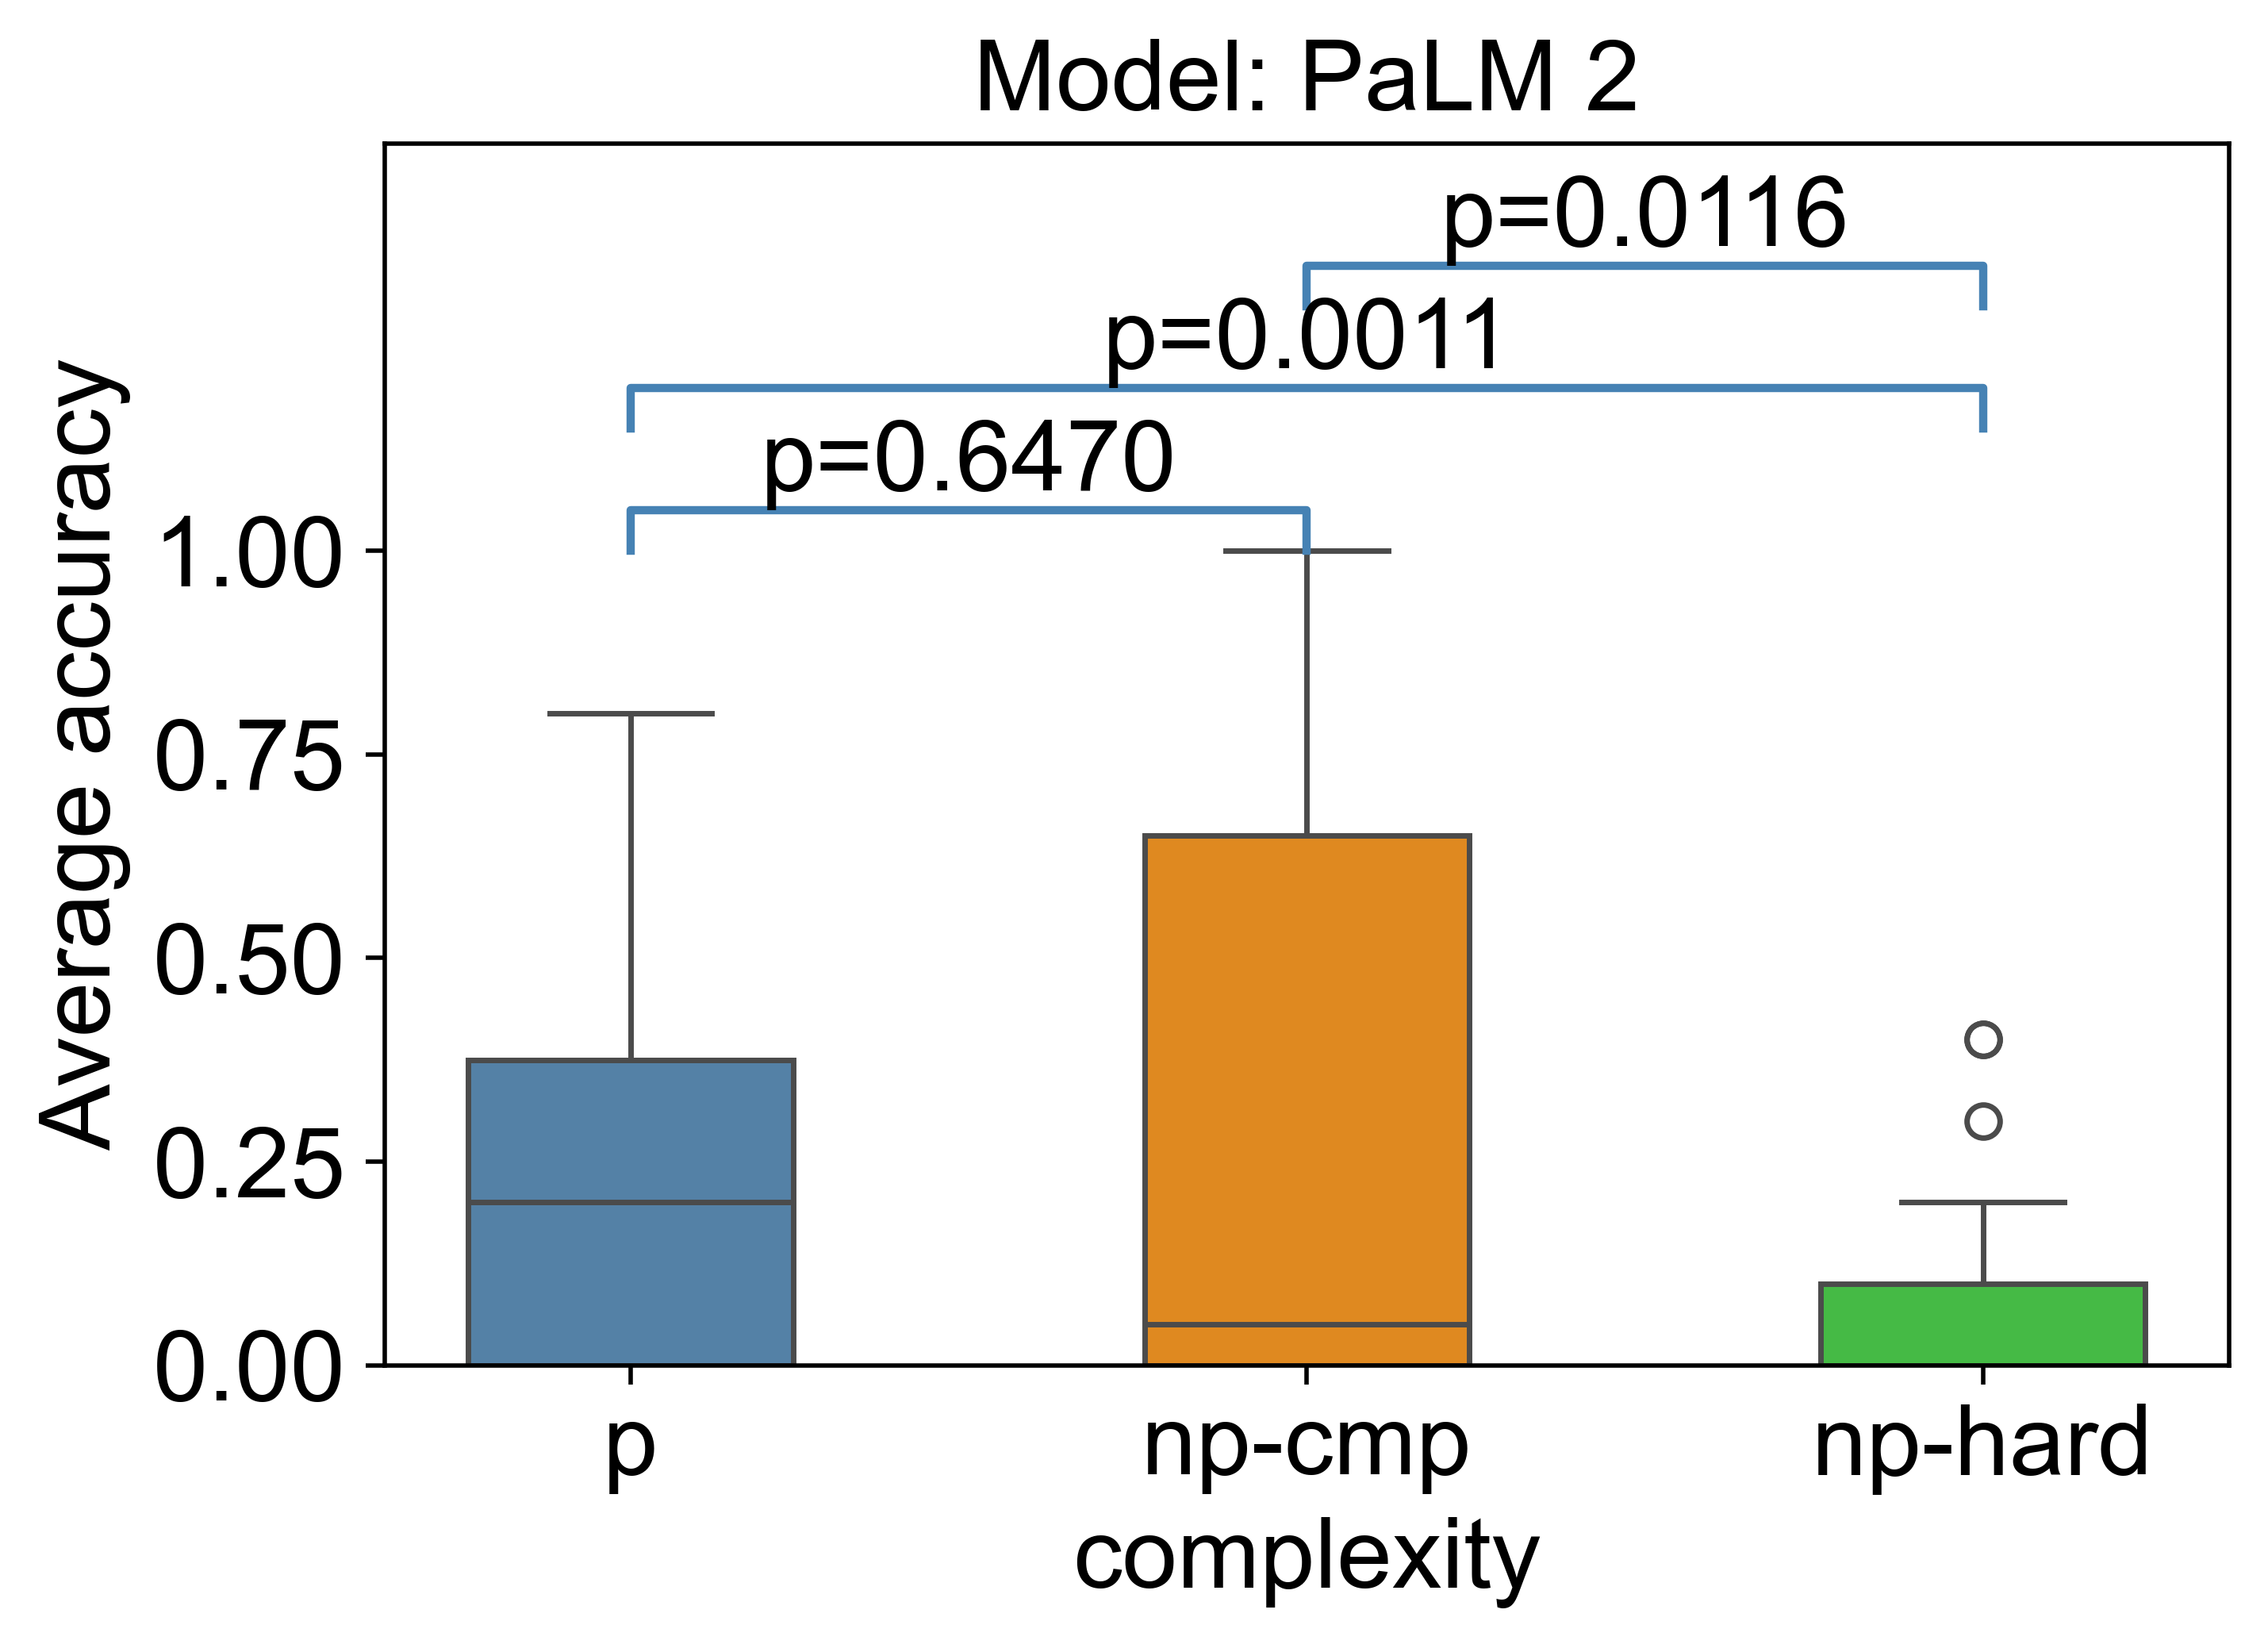

In [94]:
model = 'PaLM 2'
create_figure(model_df, model)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.9424176678315622, 0.0001340150969049987, 0.00013622860026650142]


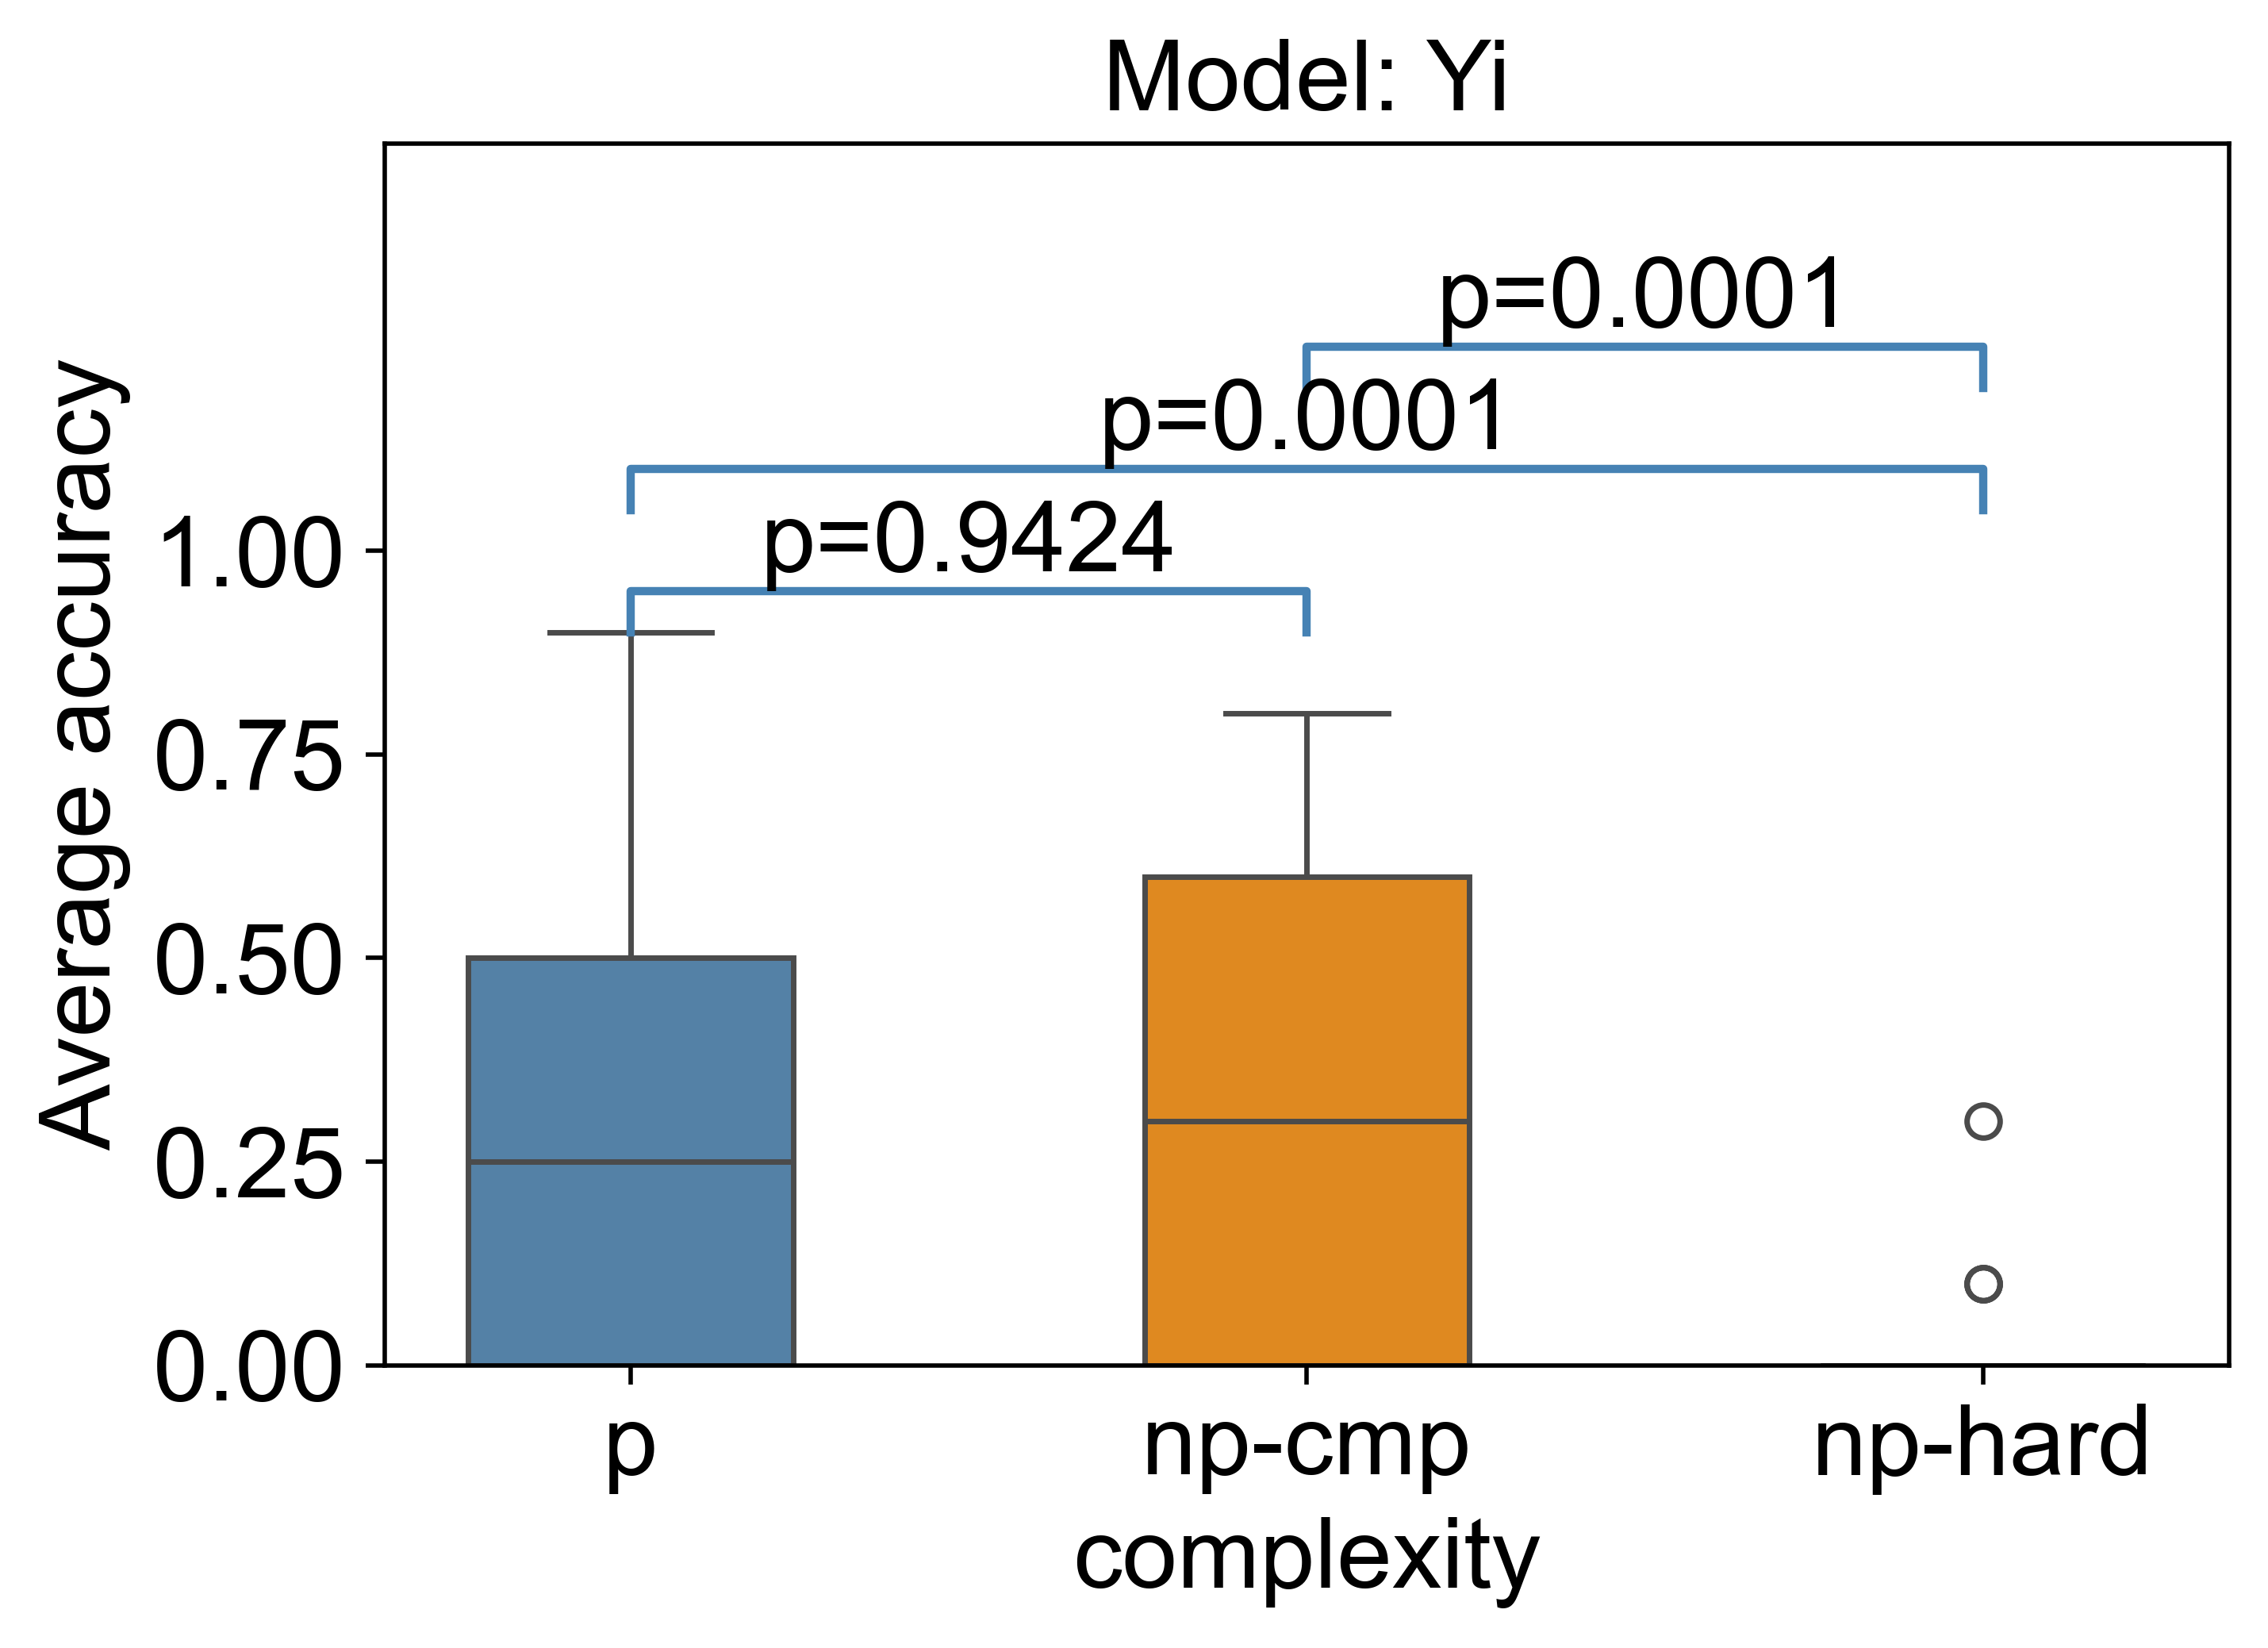

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.6688963131983239, 0.005366046661588378, 0.023654747527608485]


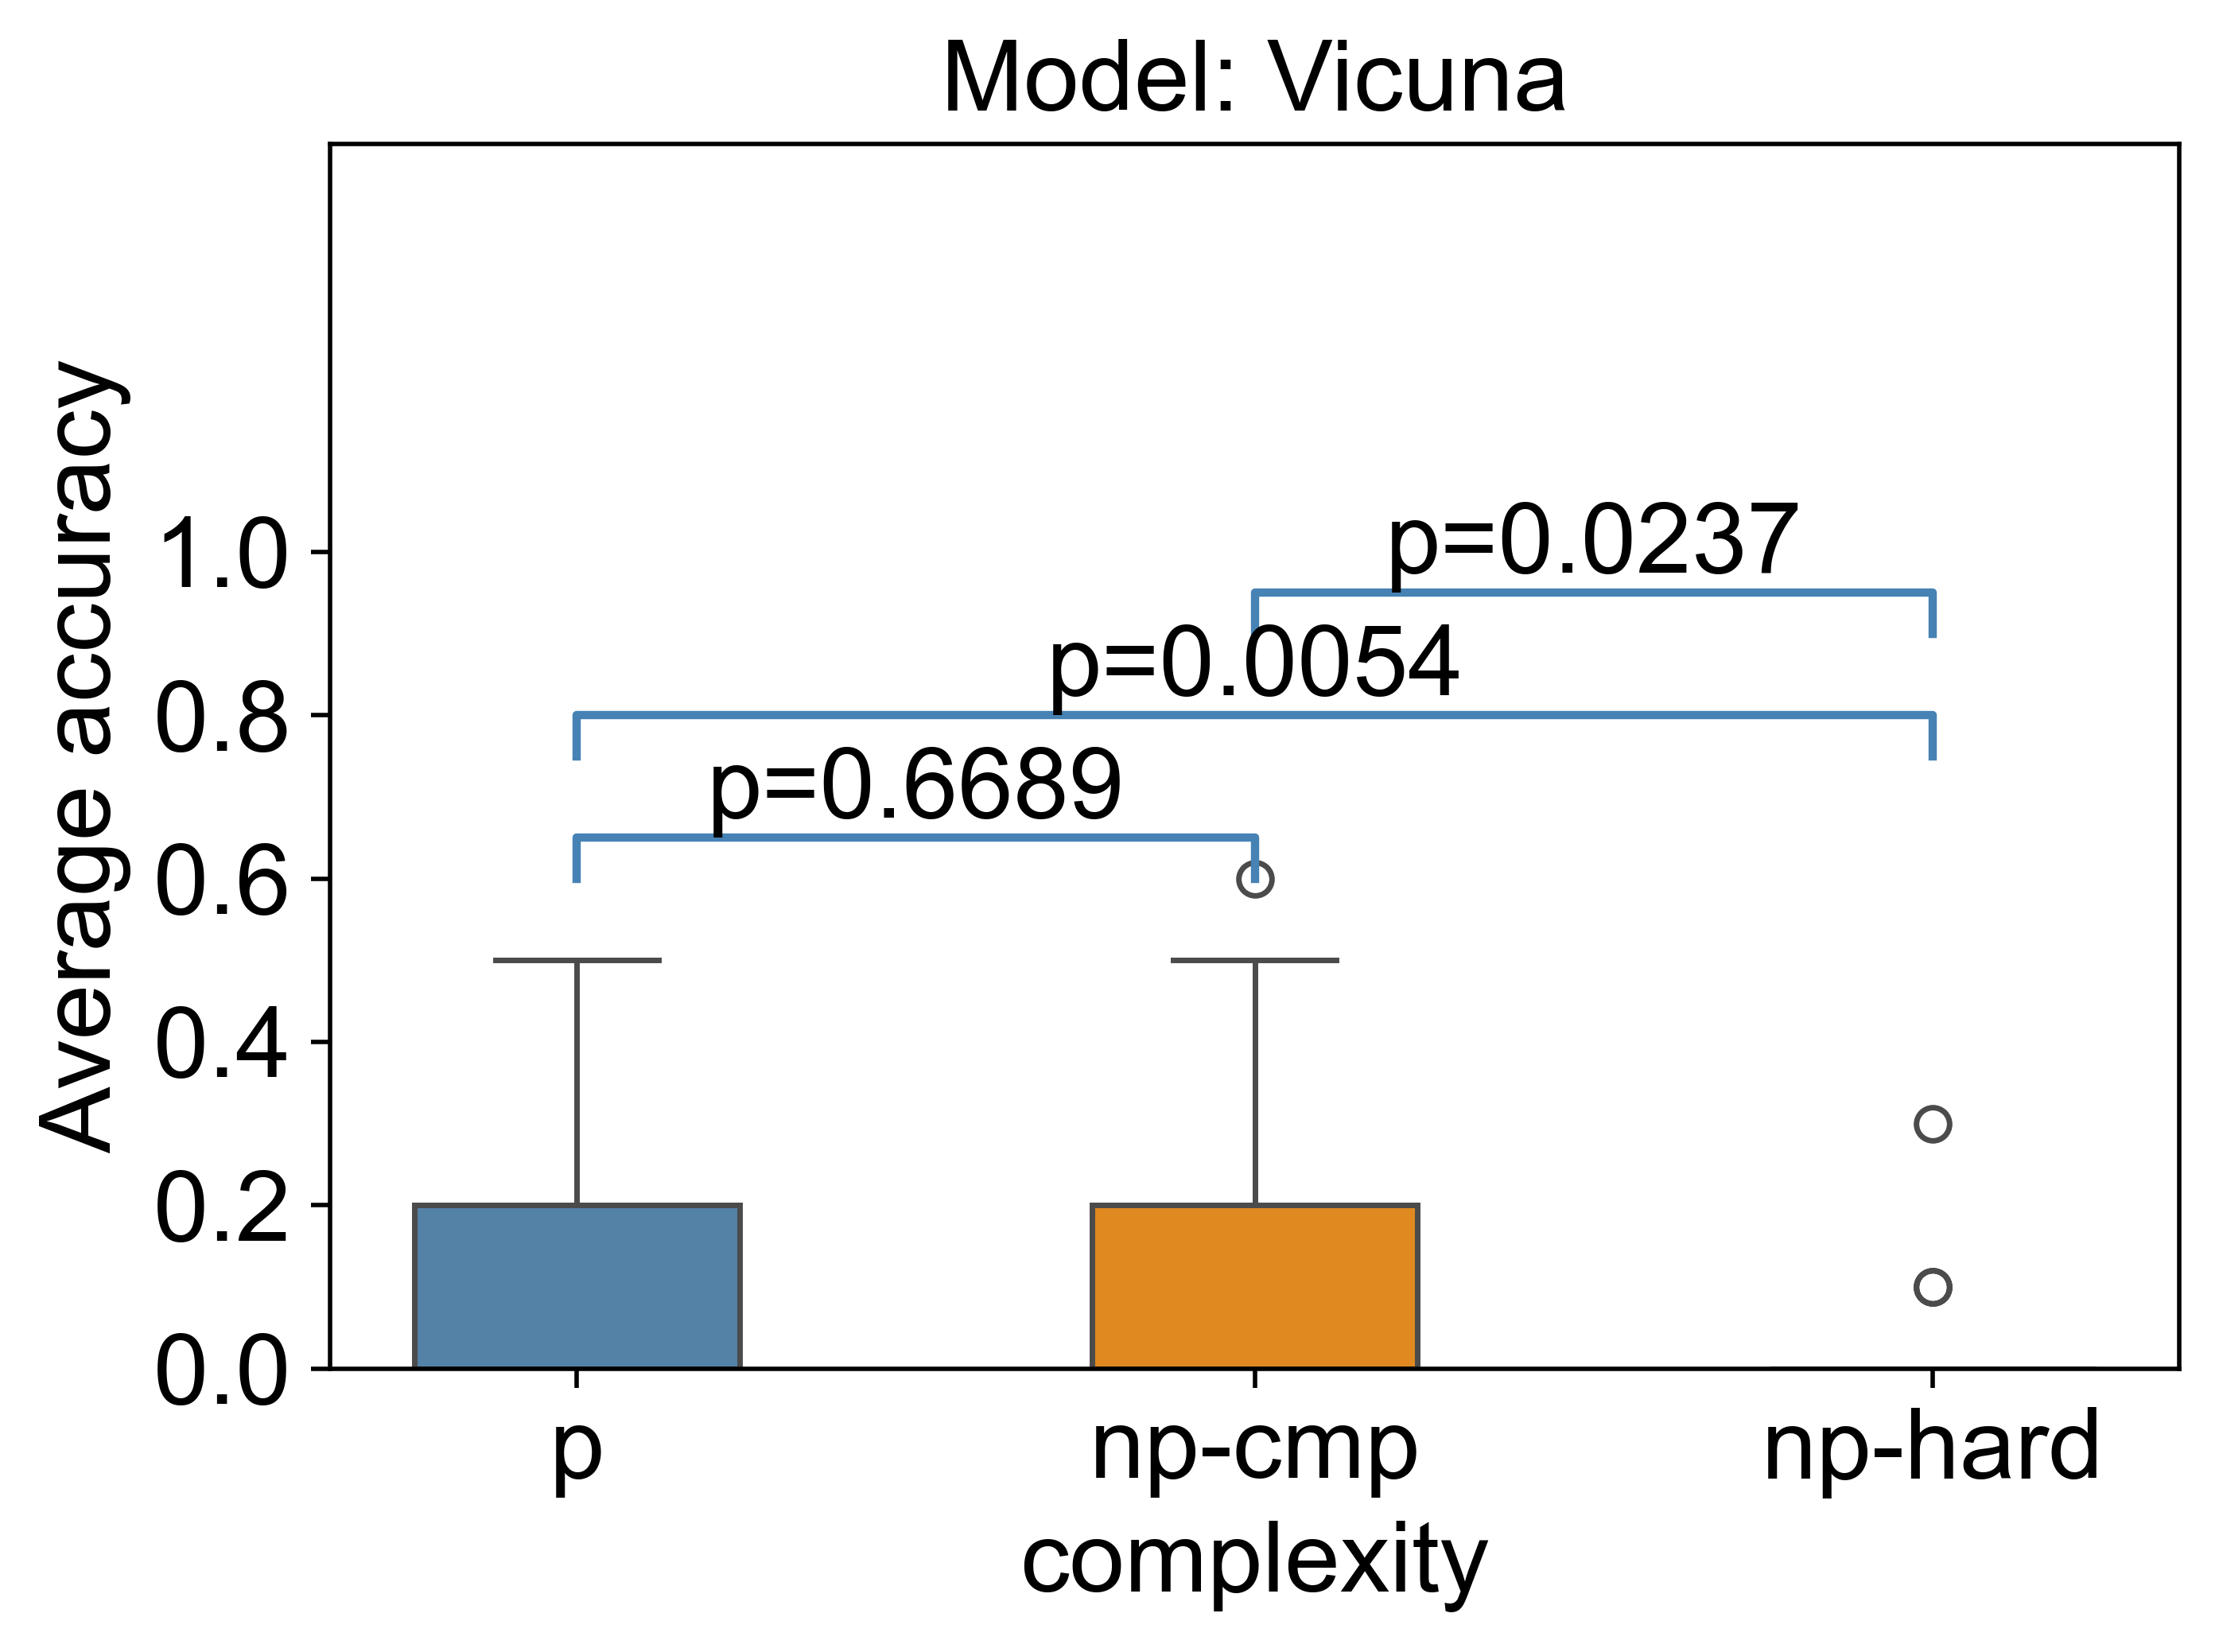

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.0004564811737708361, 0.29139532094713094, 0.00042946111168403465]


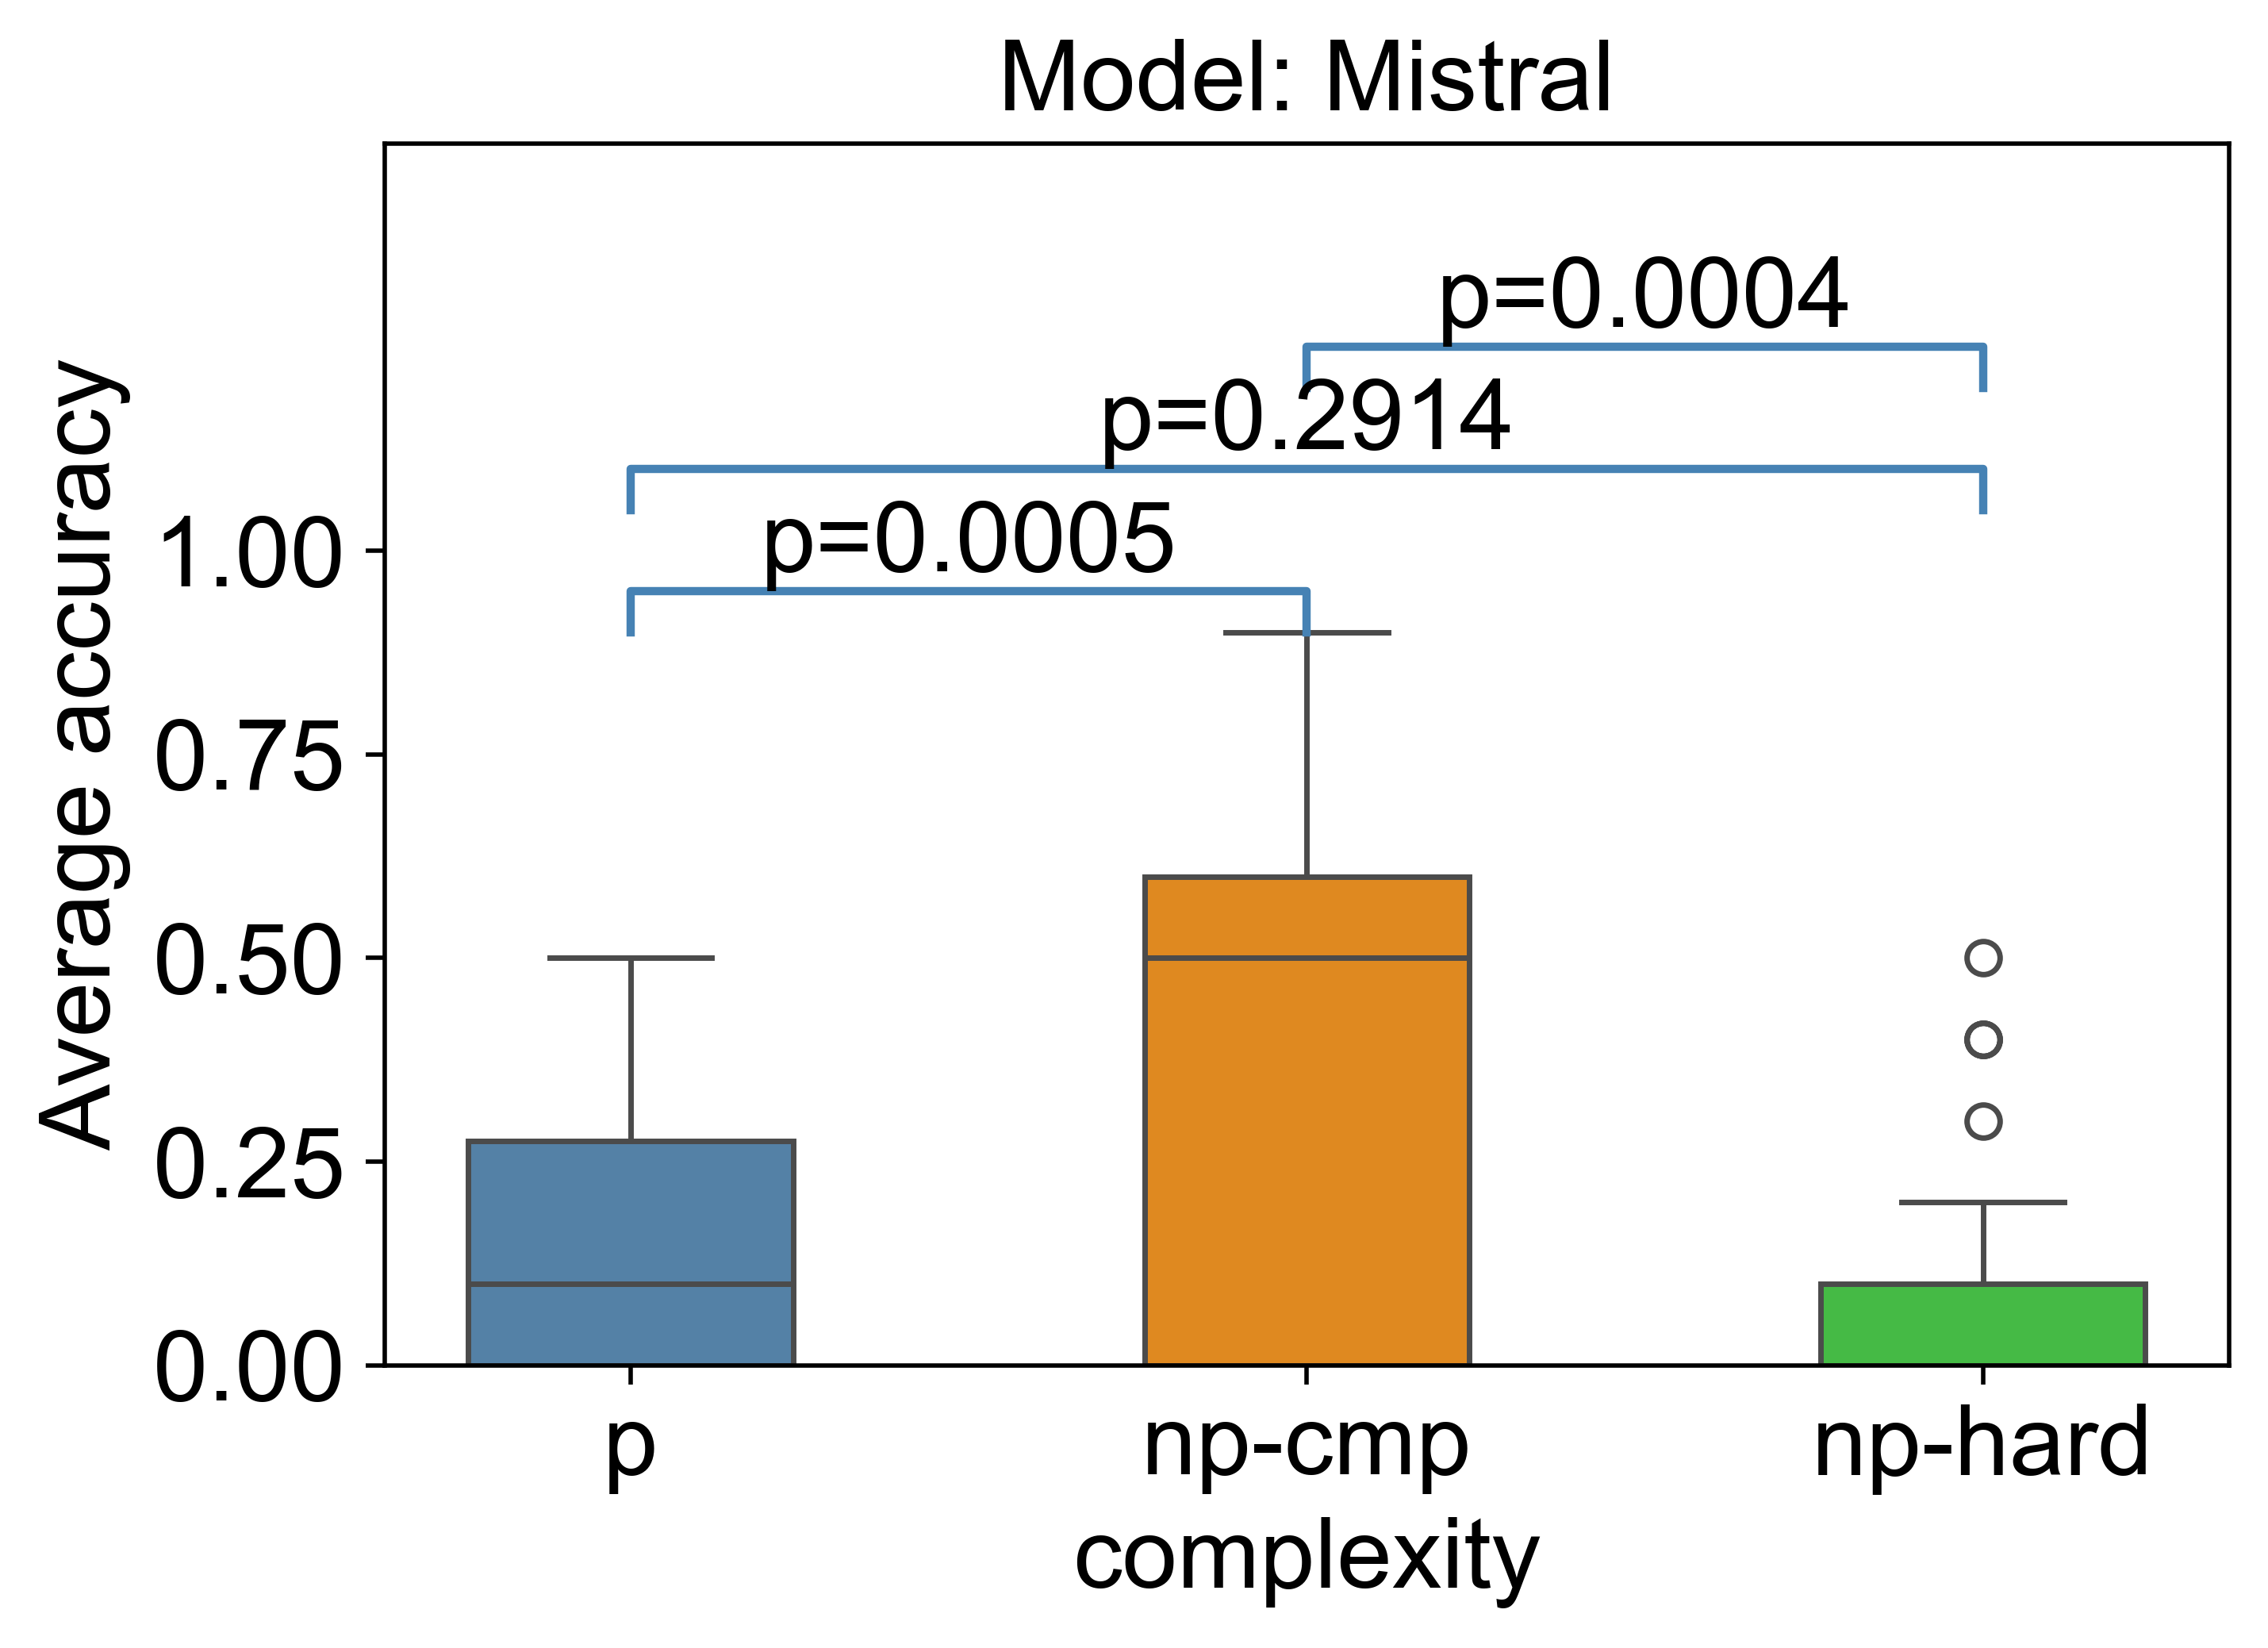

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.1922799228115477, 0.004010951238828849, 0.010428581833434265]


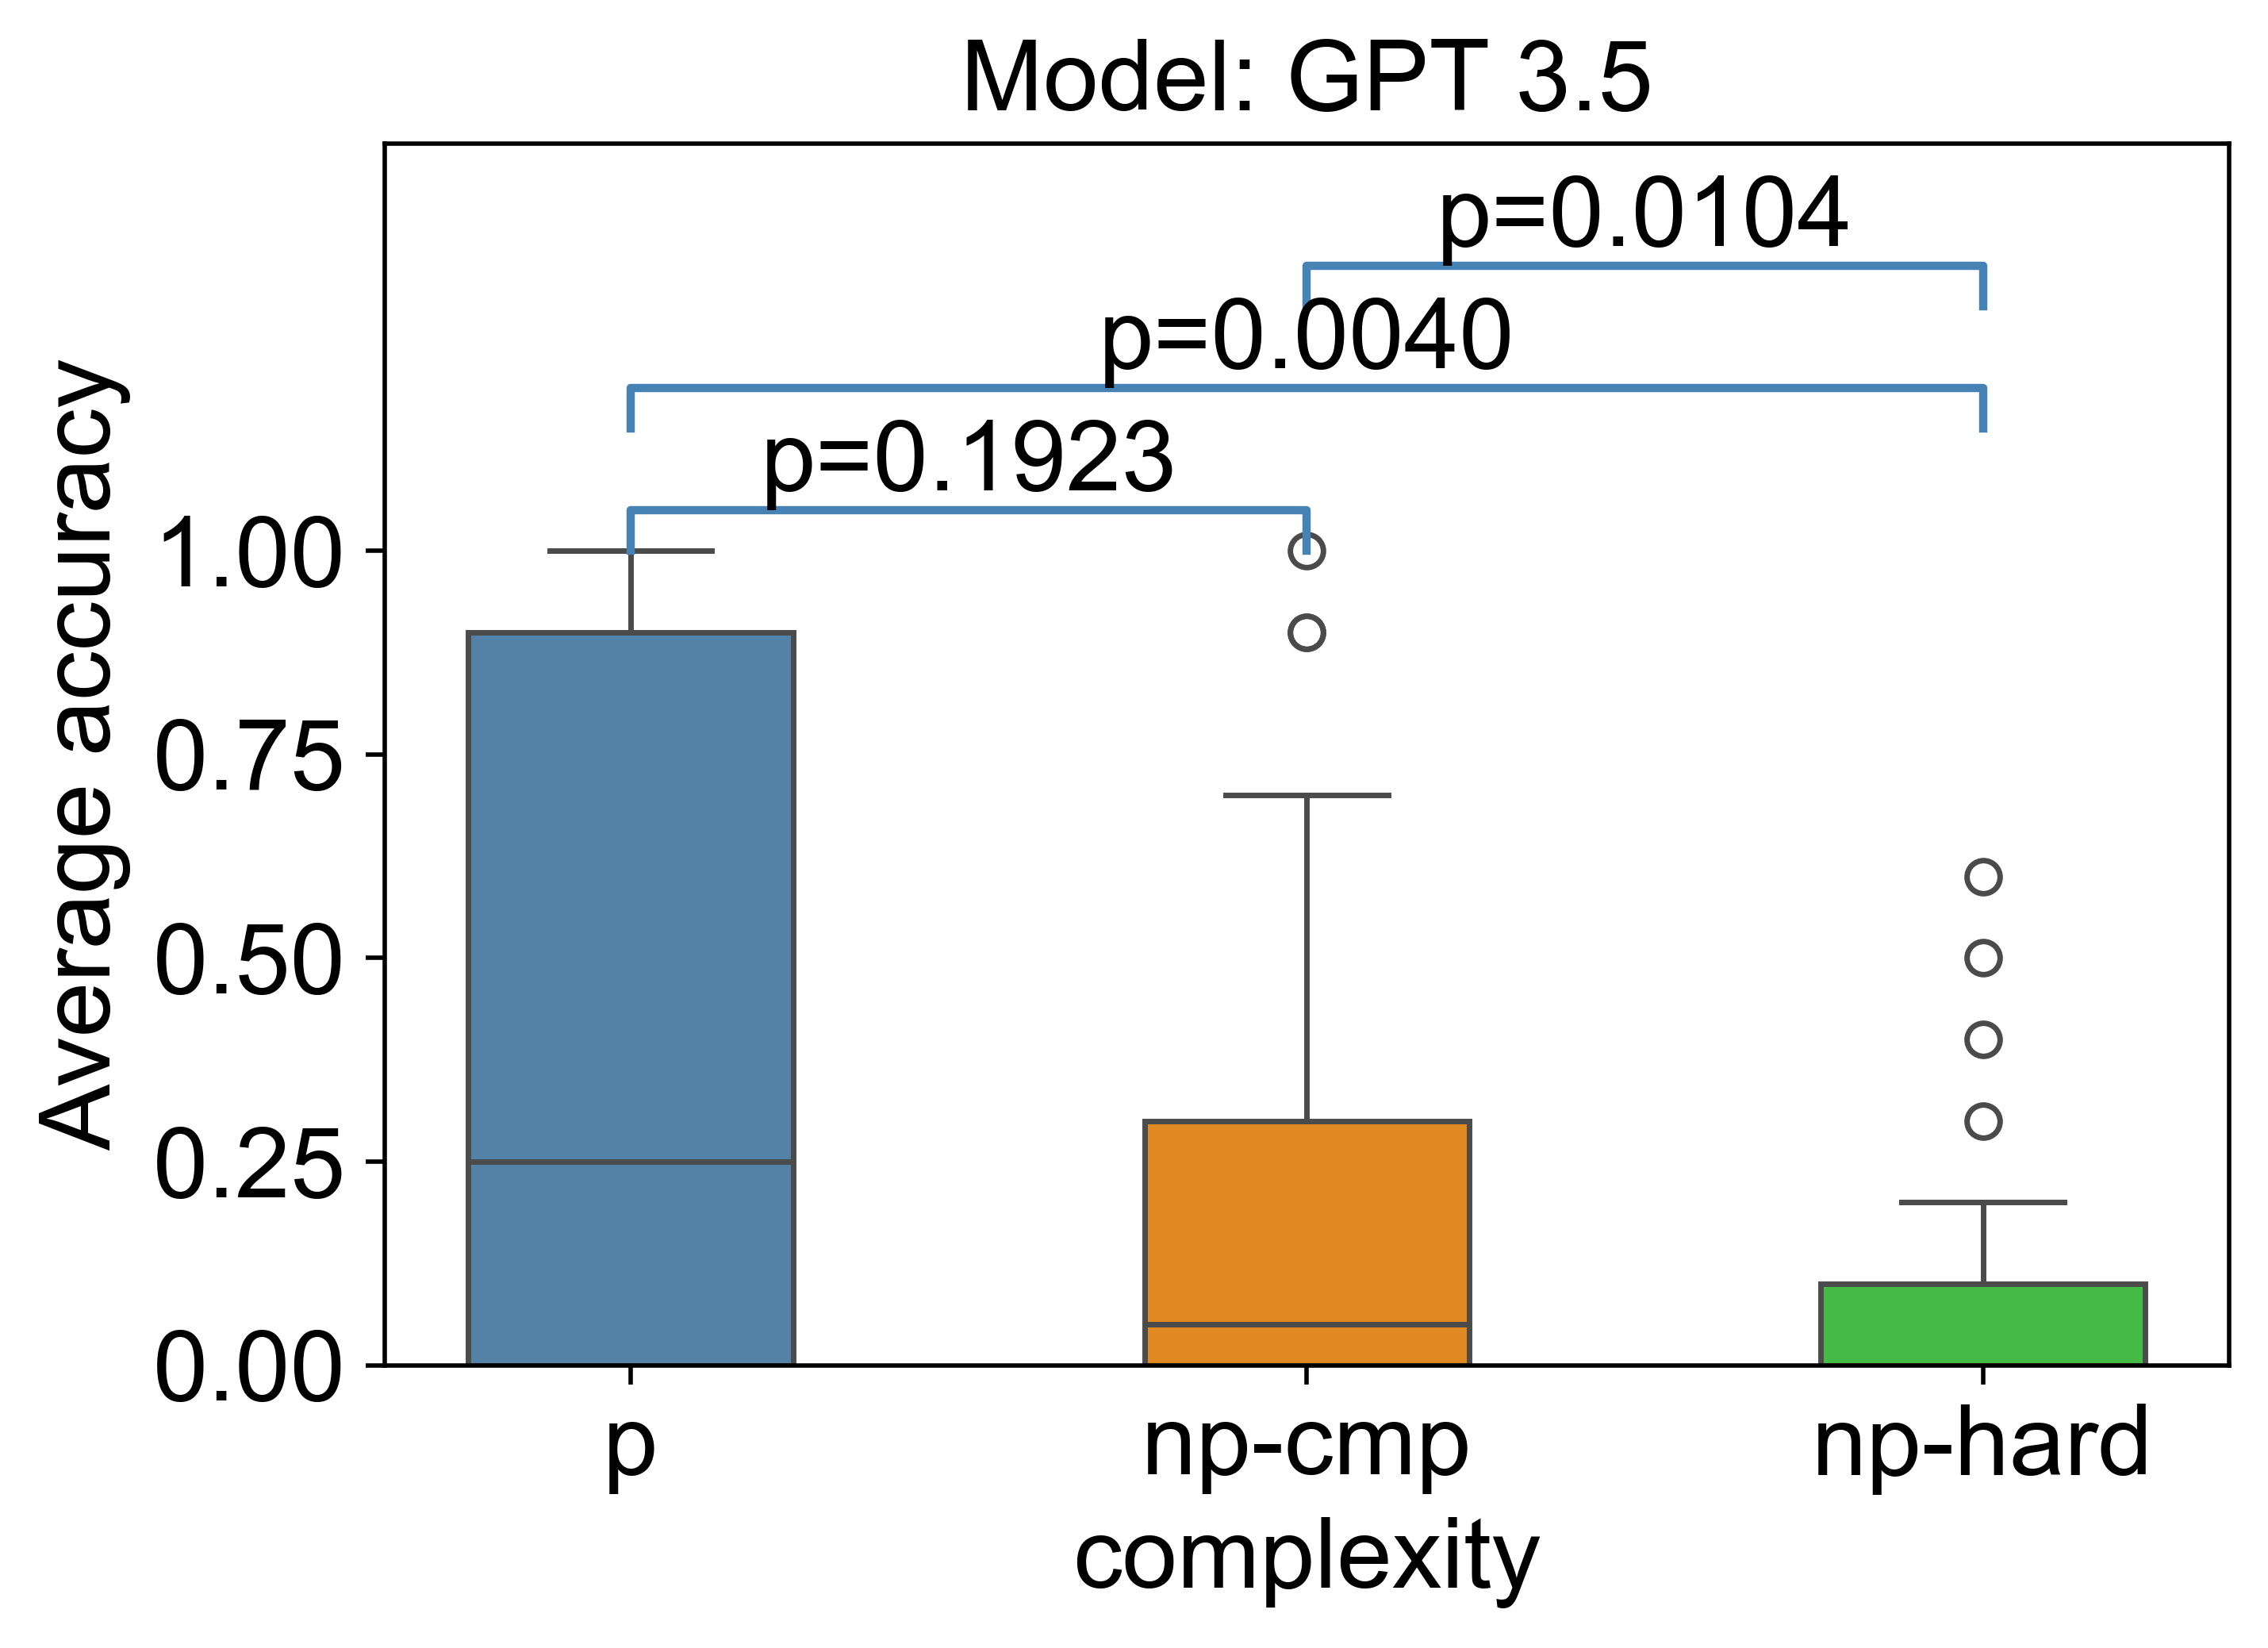

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.011209733383895203, 0.011209733383895203, 1.0]


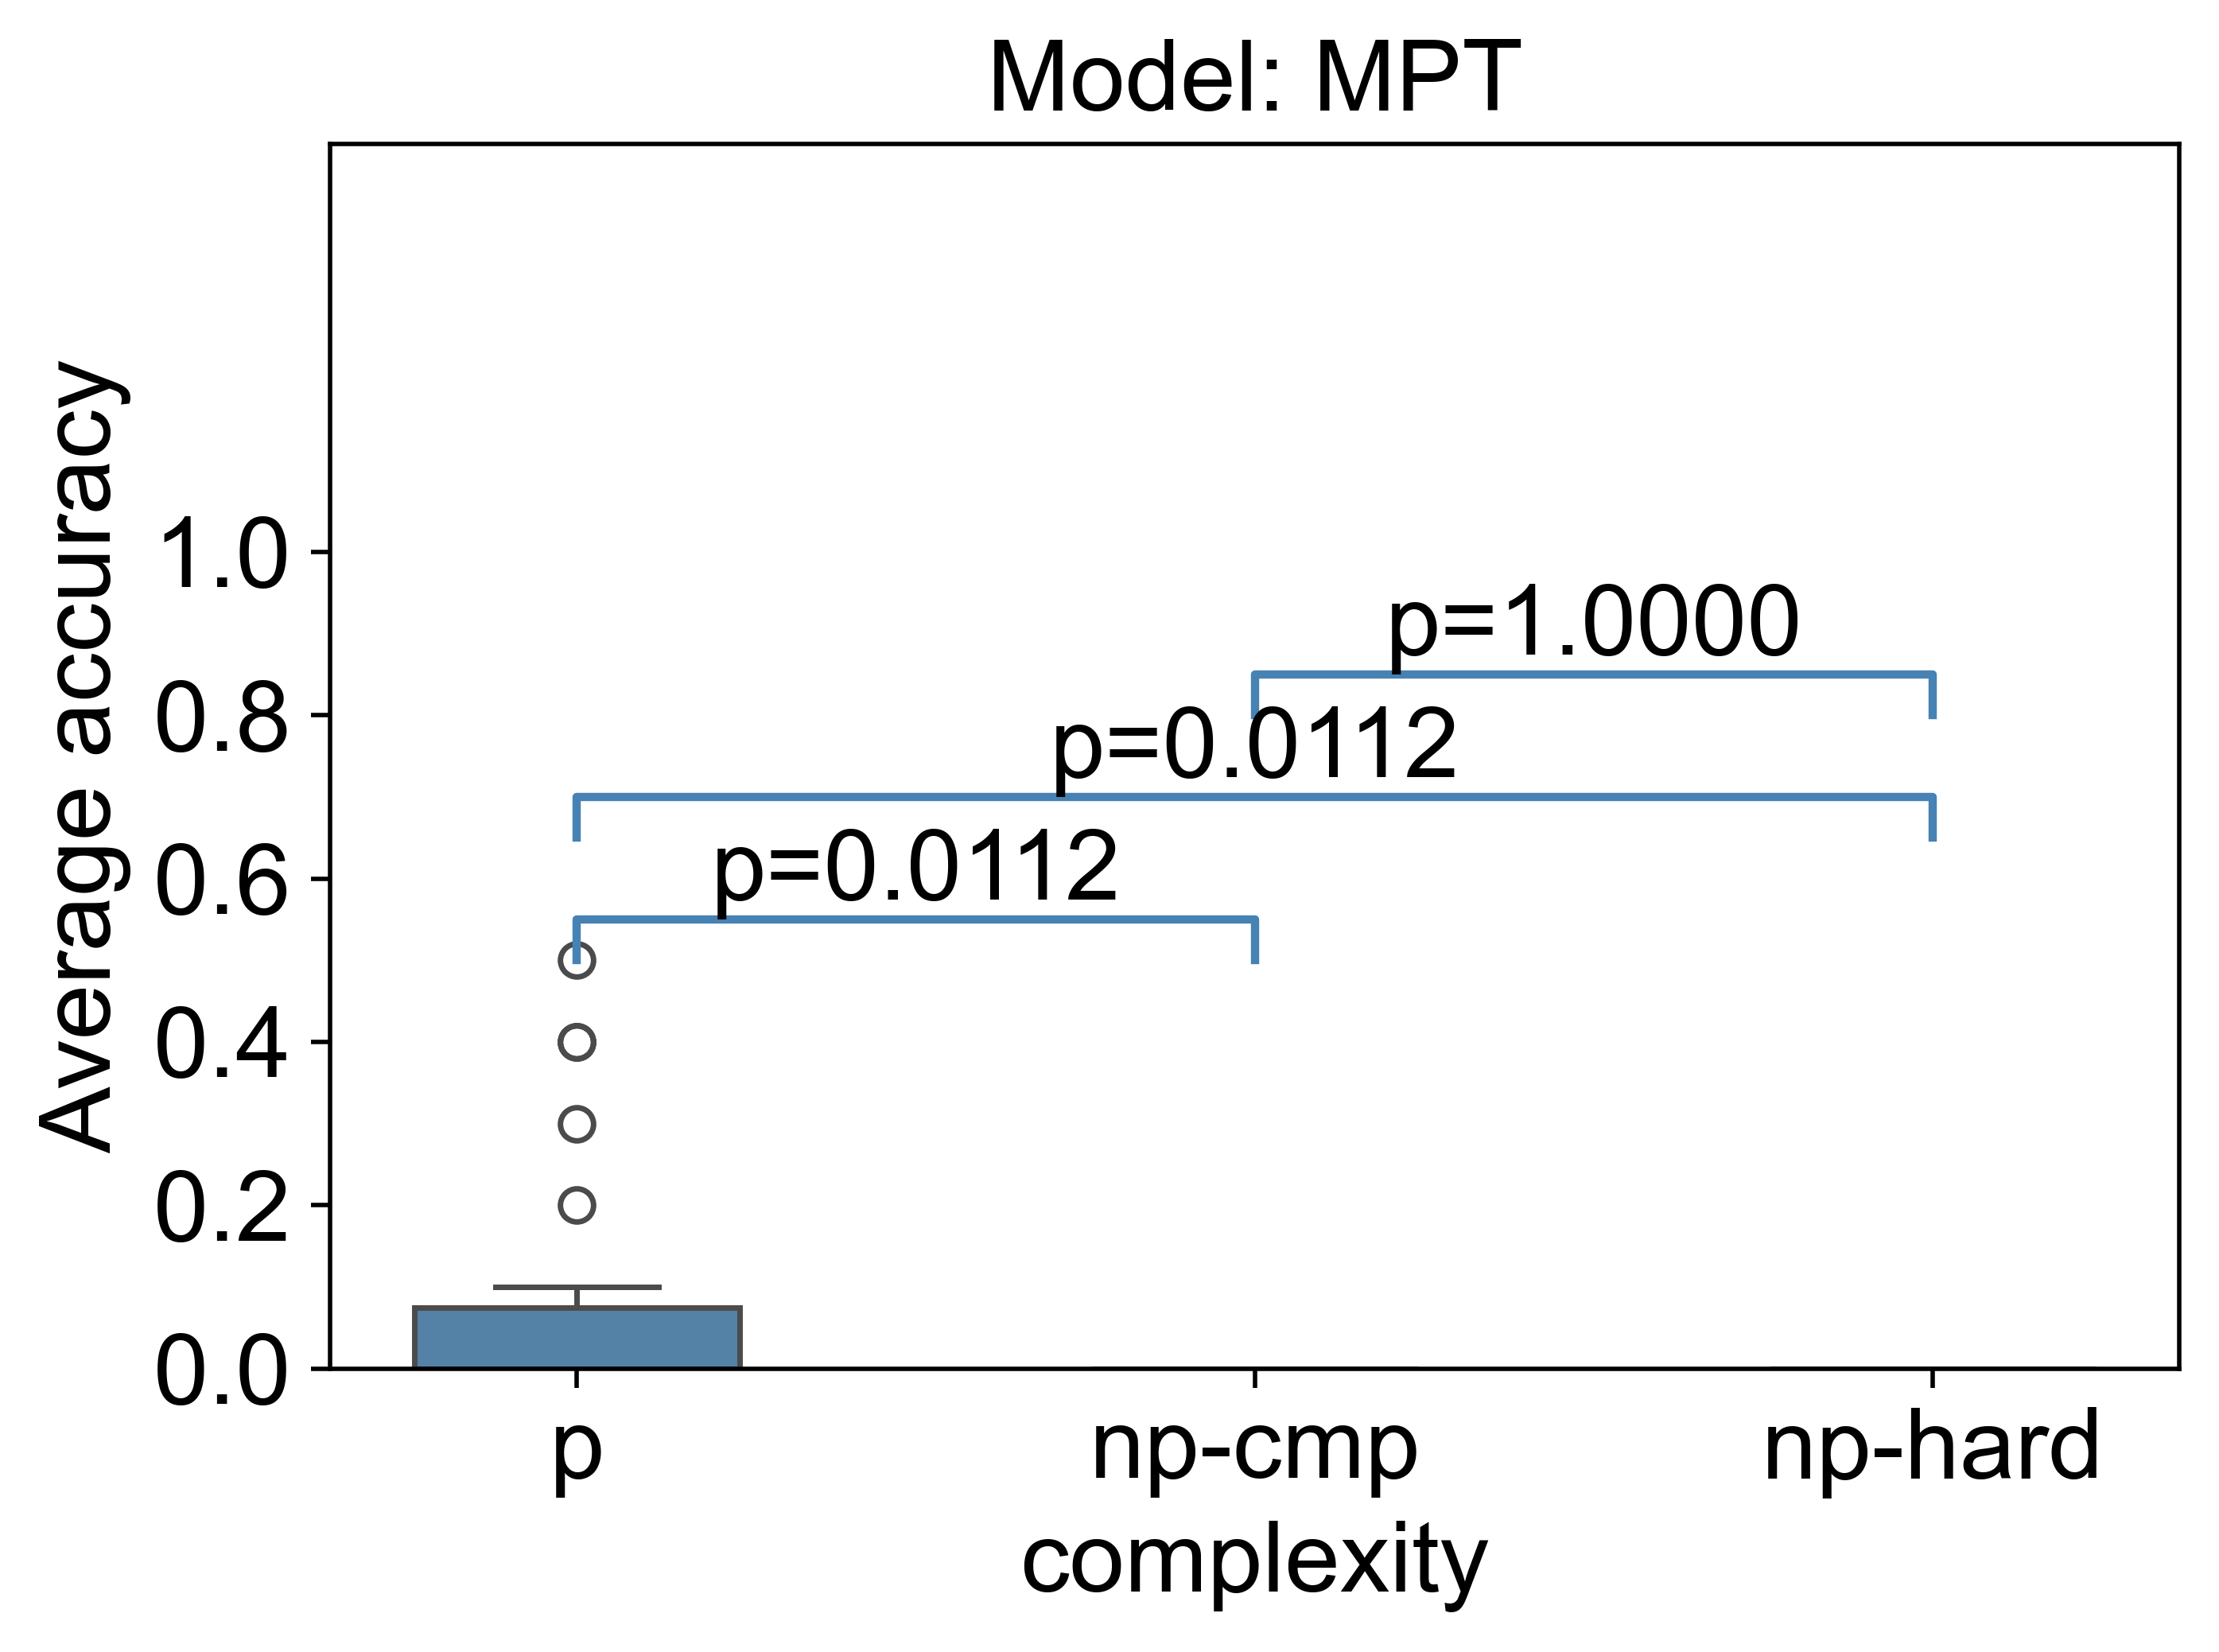

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.07324407435953617, 0.0002926909889740204, 8.934345385995537e-05]


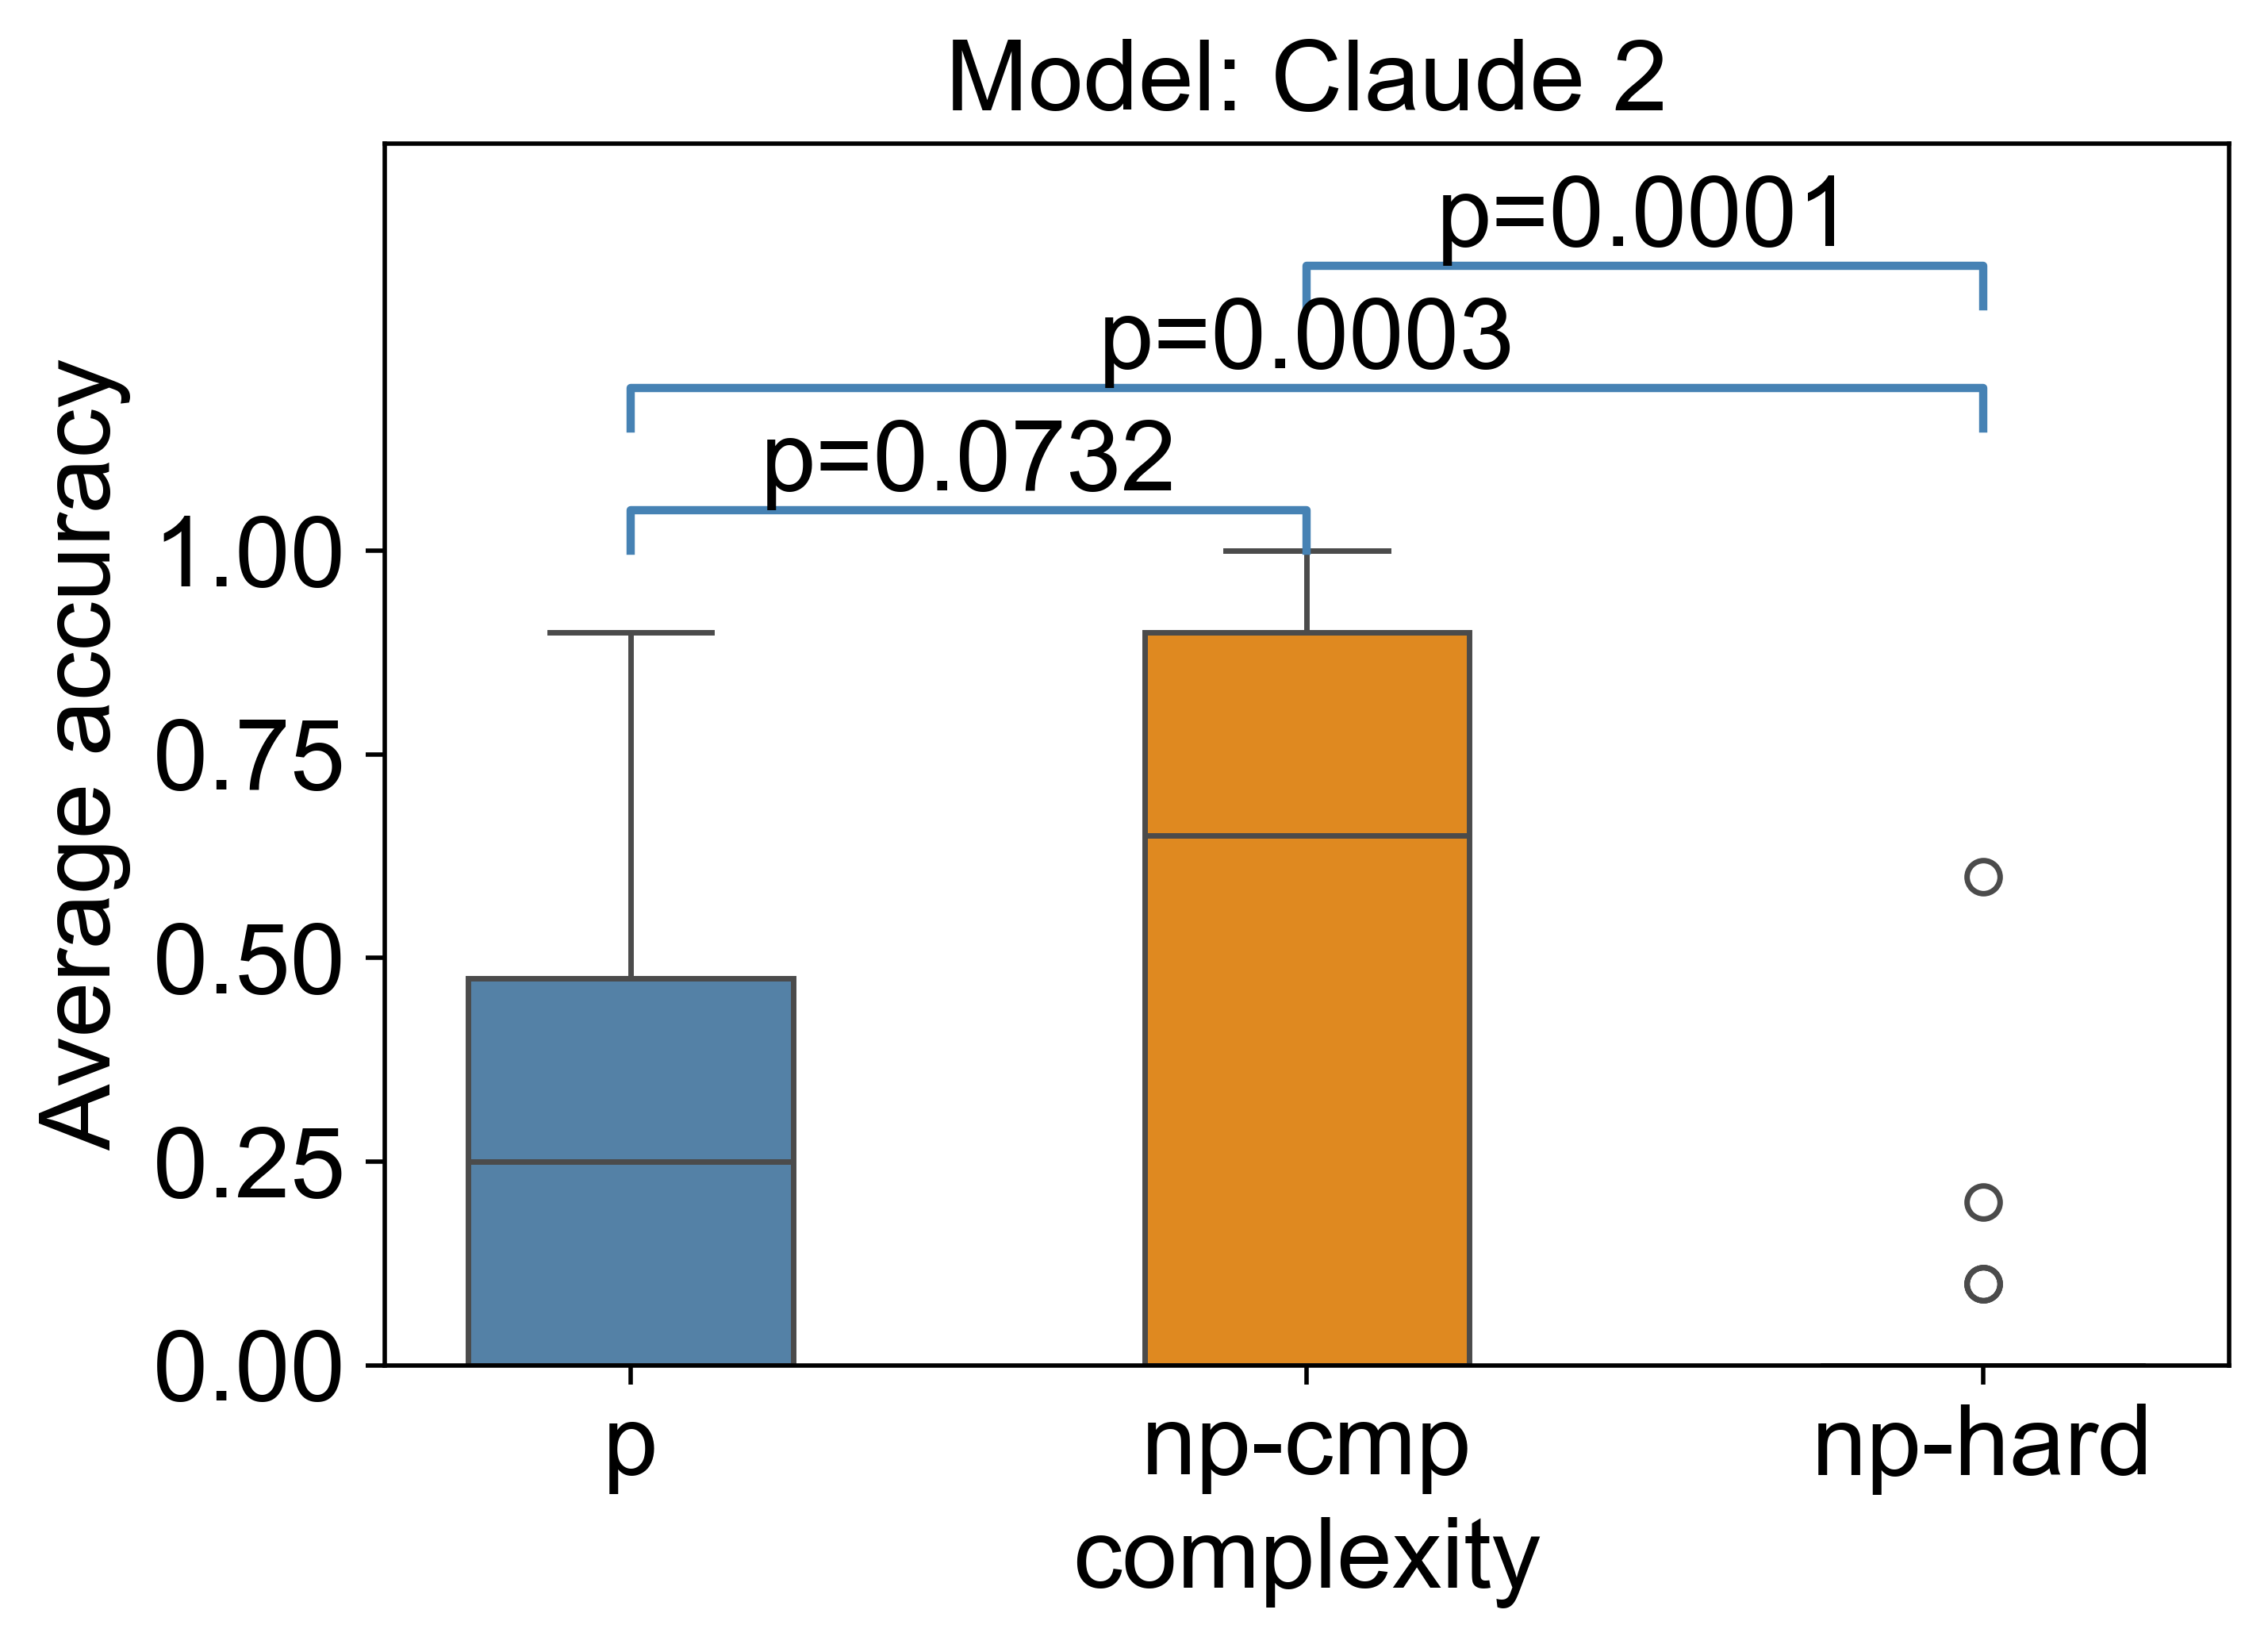

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.033095369830602454, 3.4418527376441033e-06, 0.0031723680985920035]


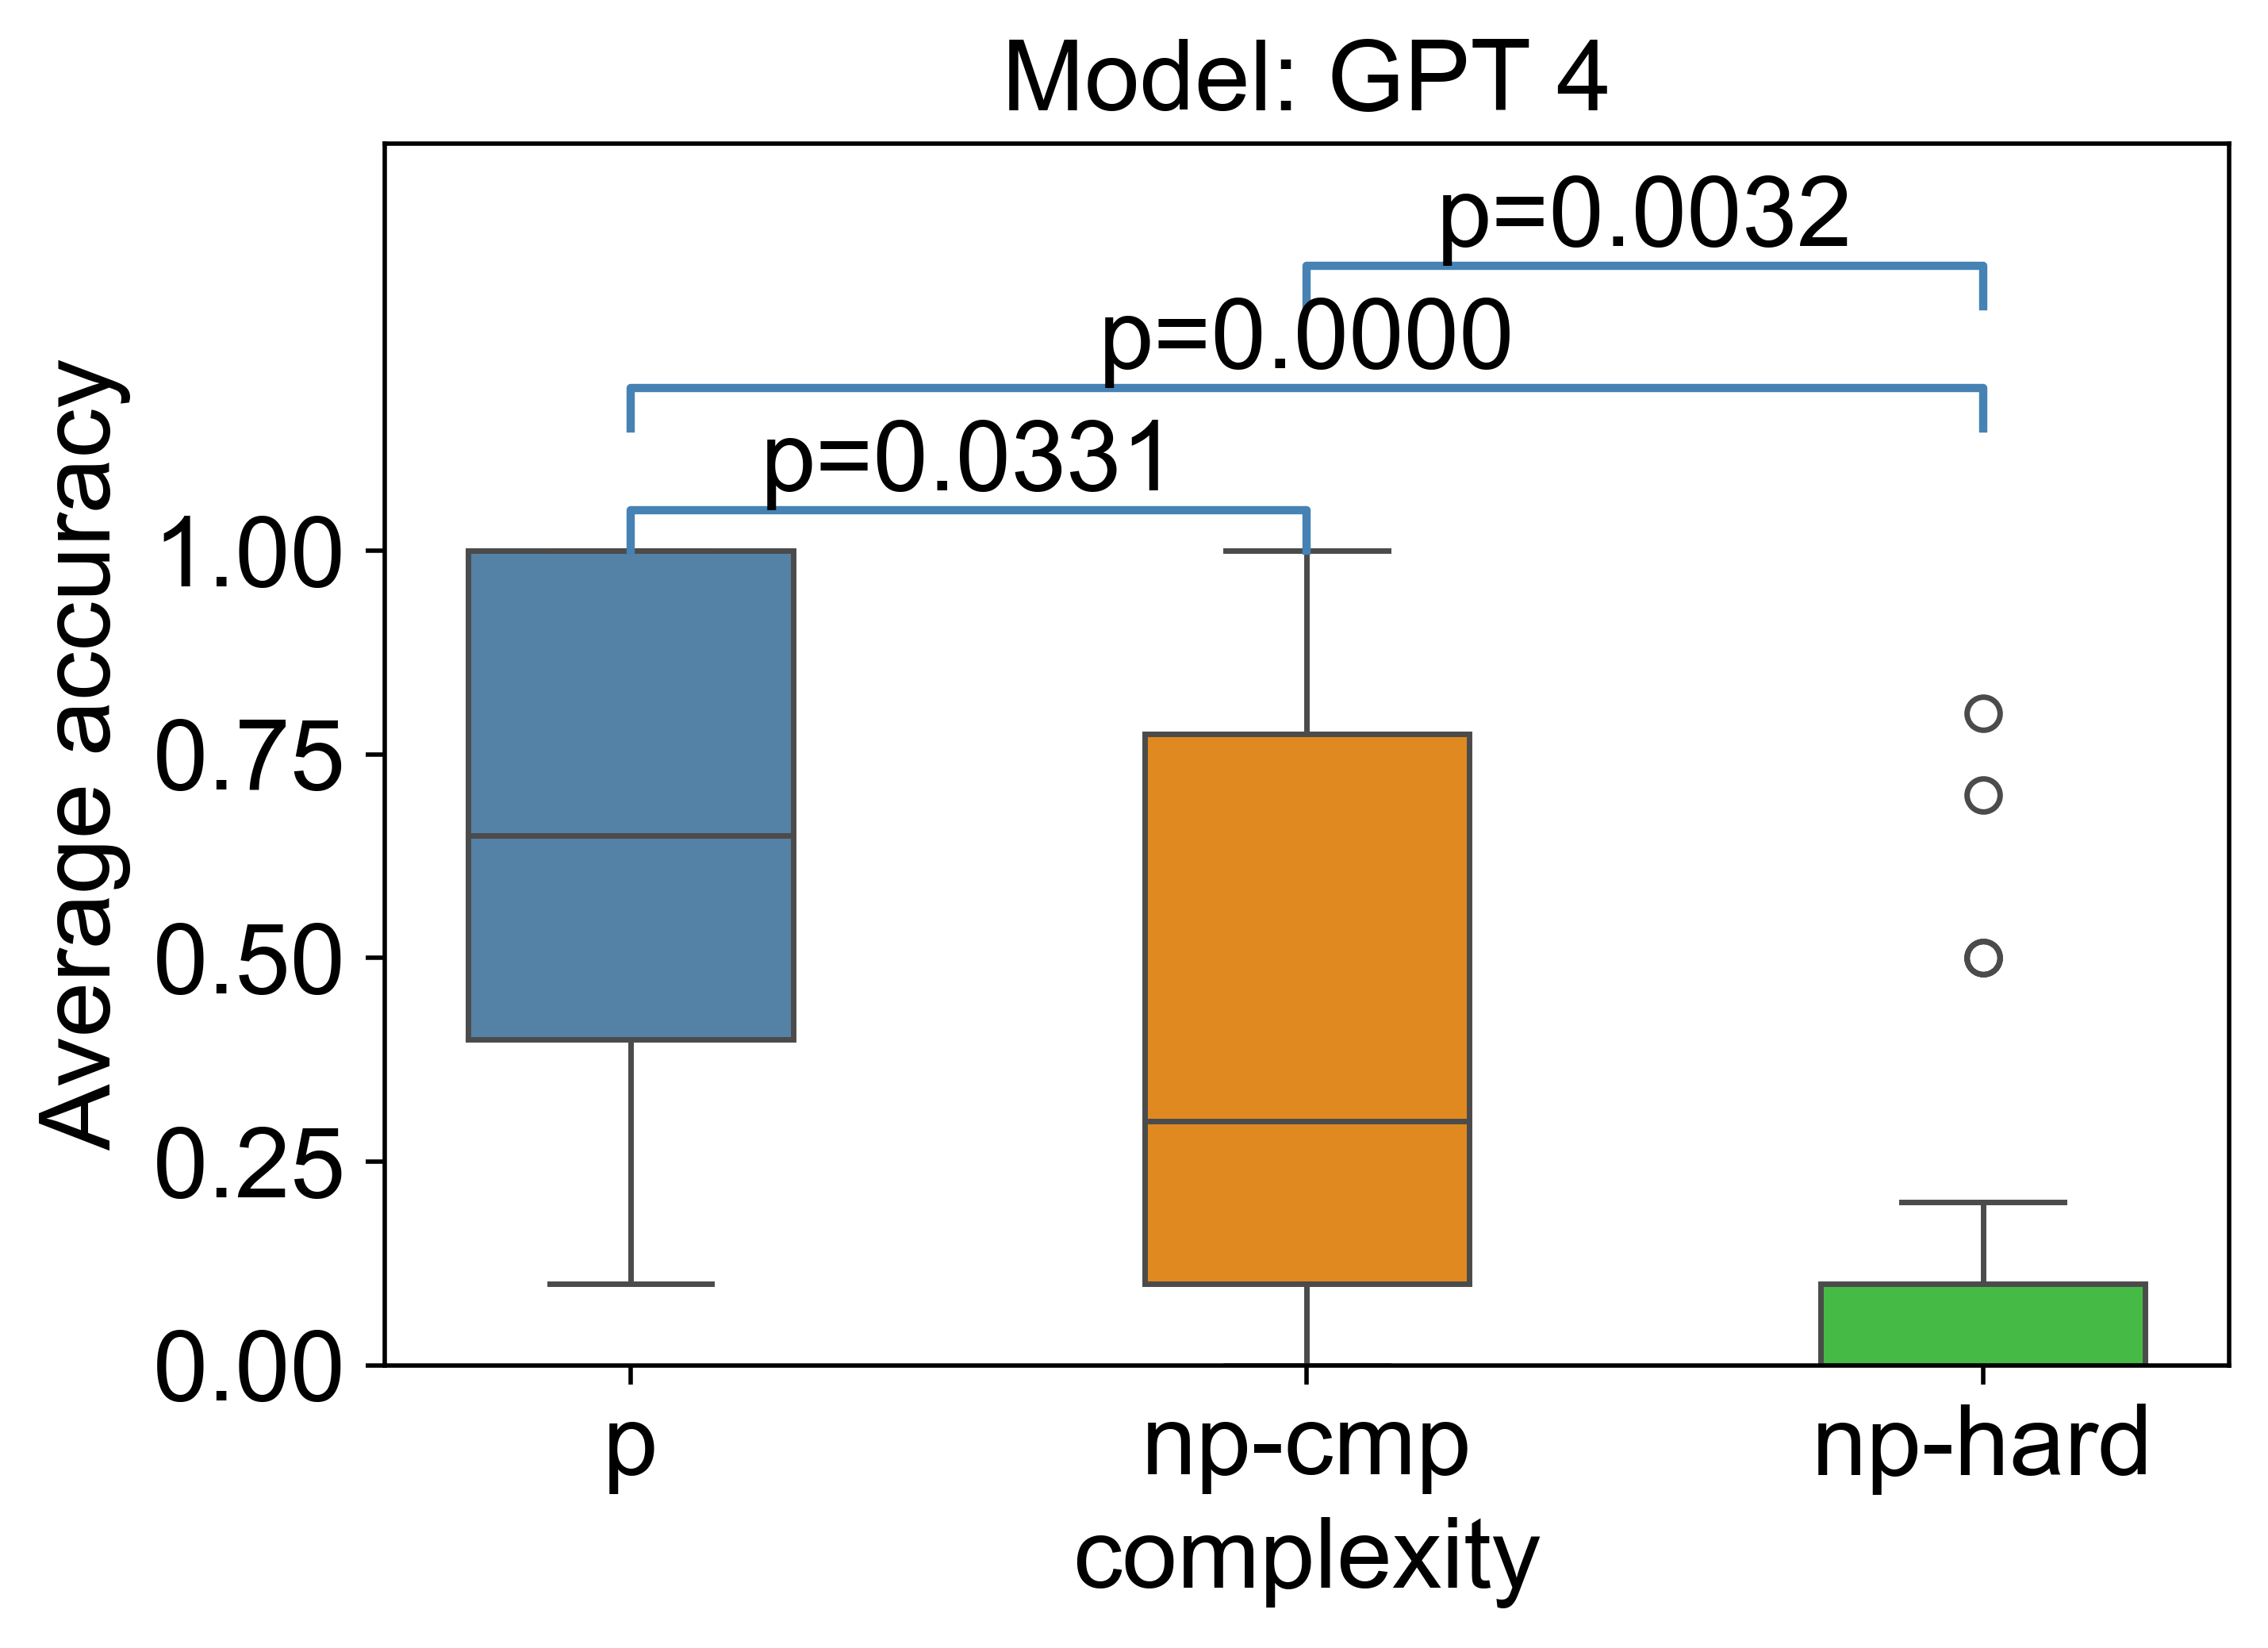

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.007264382942252025, 0.010119396732878637, 0.15729920705028502]


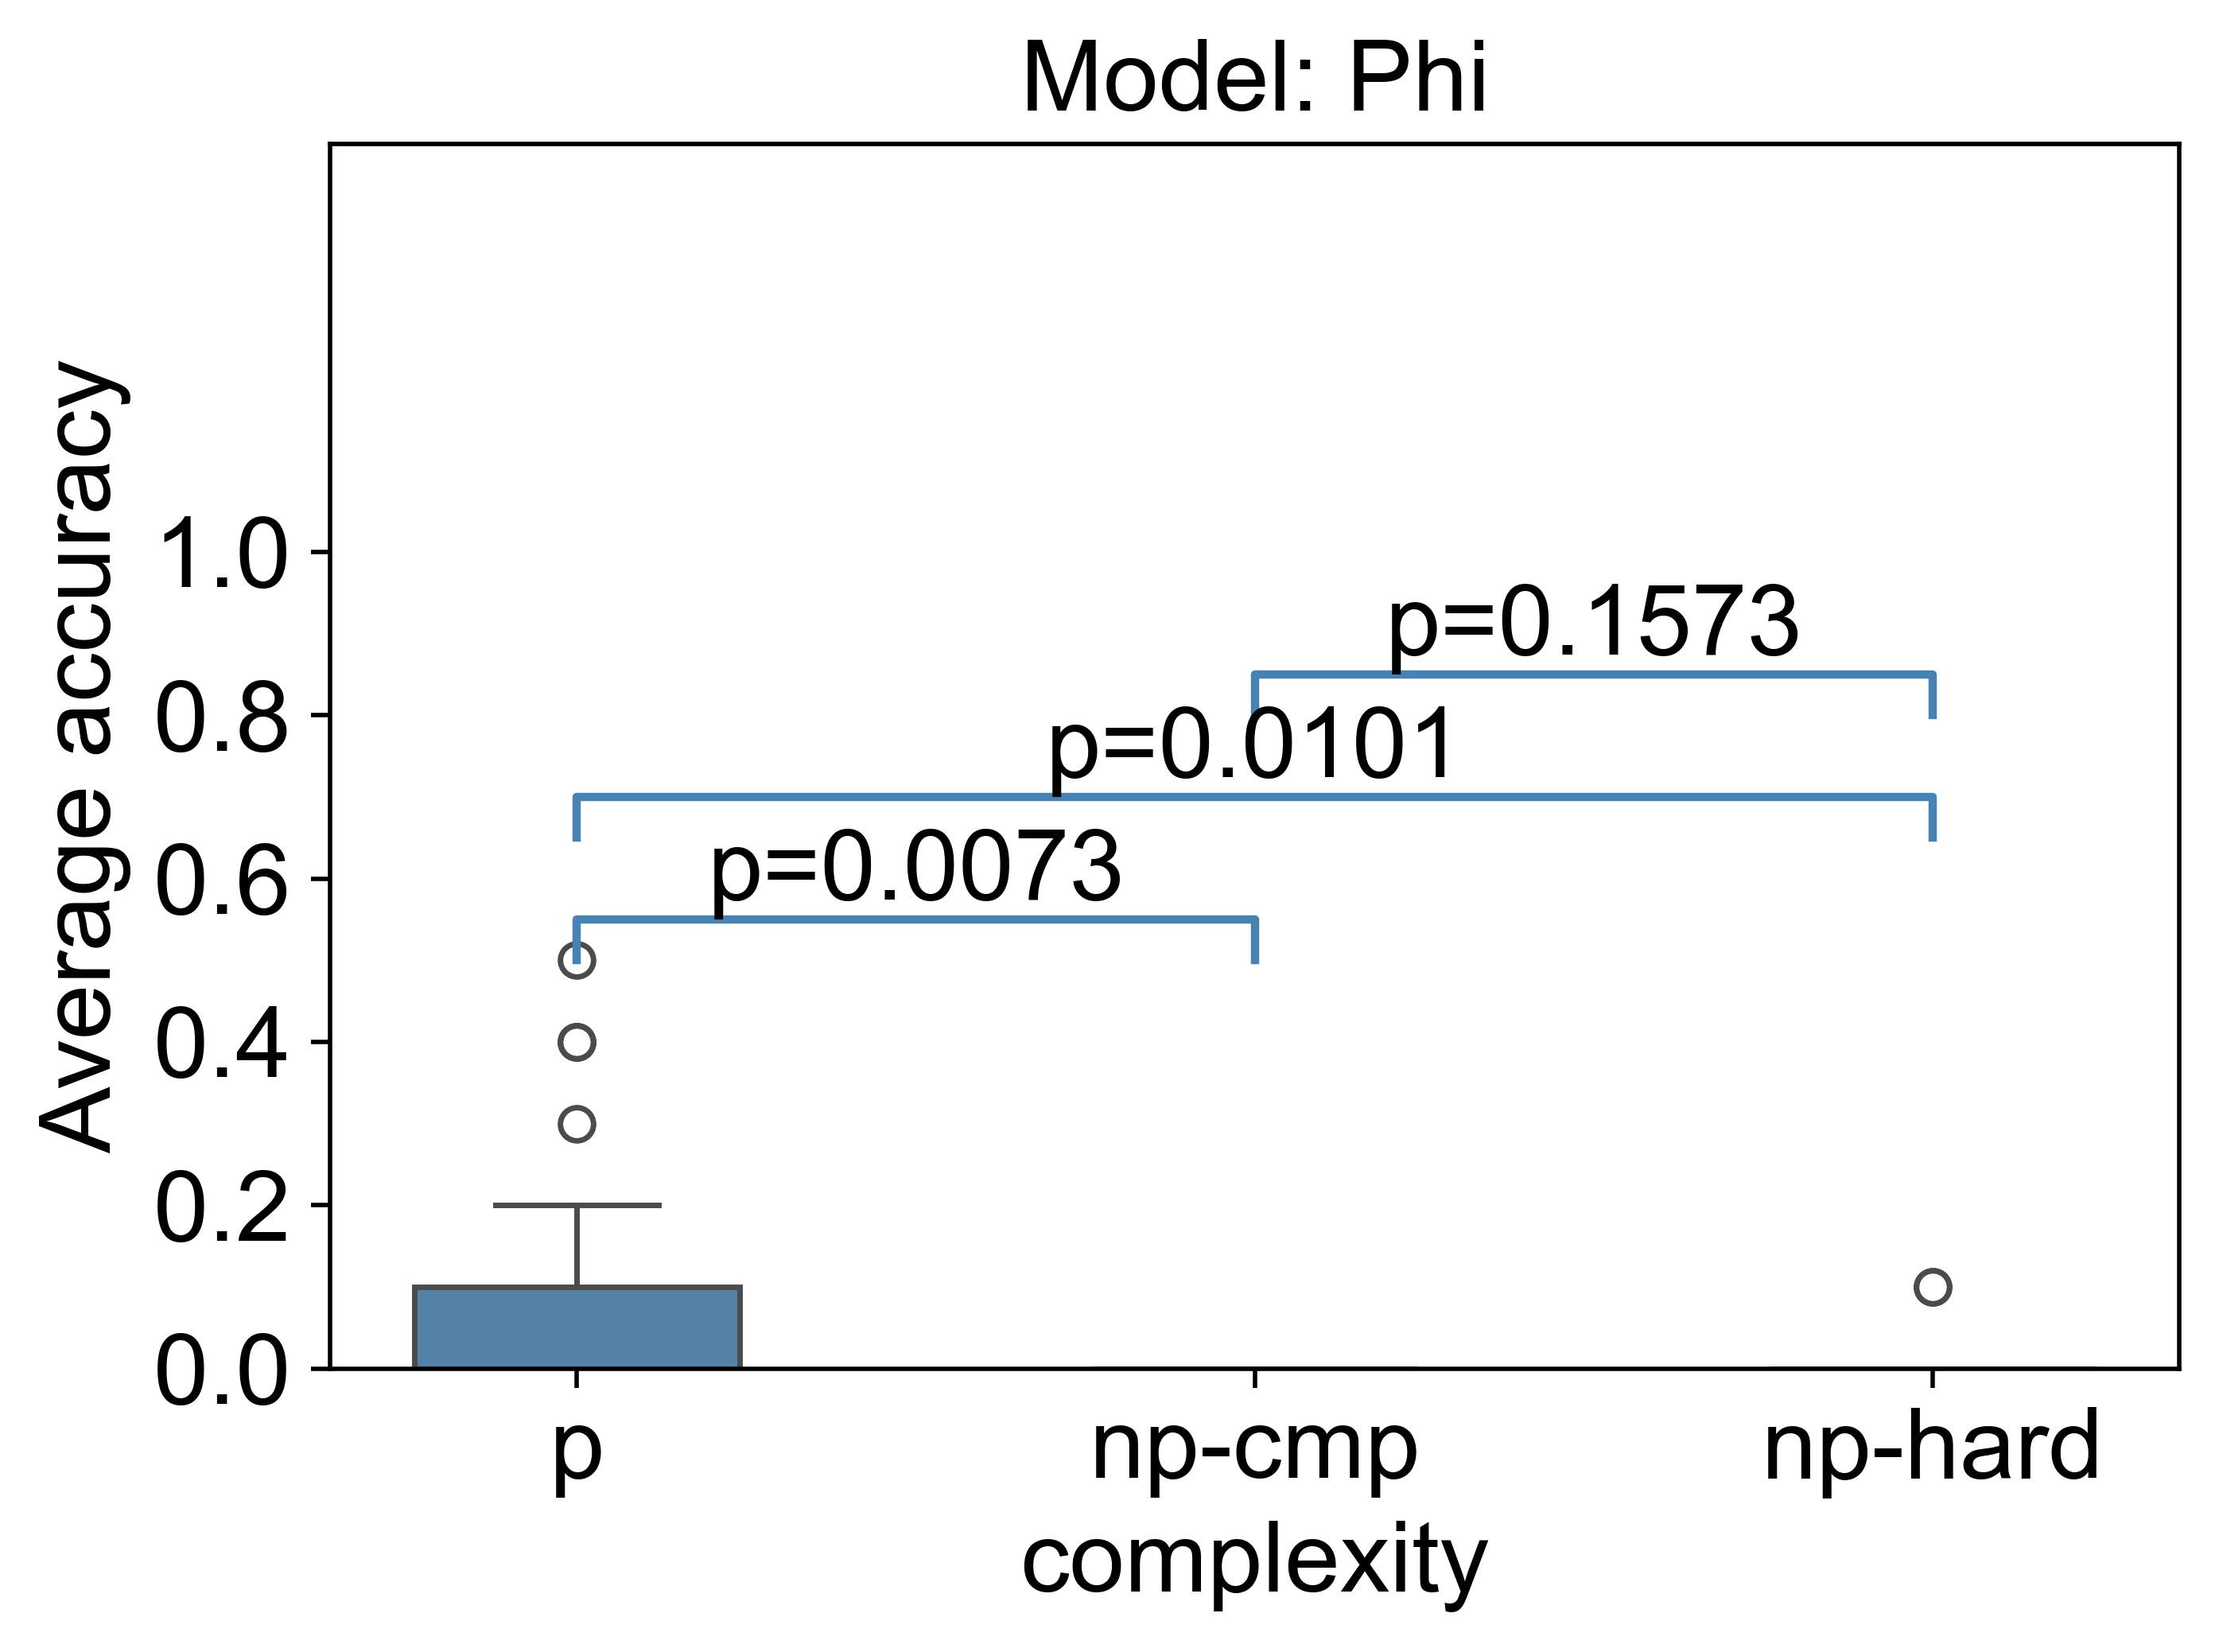

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.6470224041052598, 0.0011326334763191643, 0.011554663860090469]


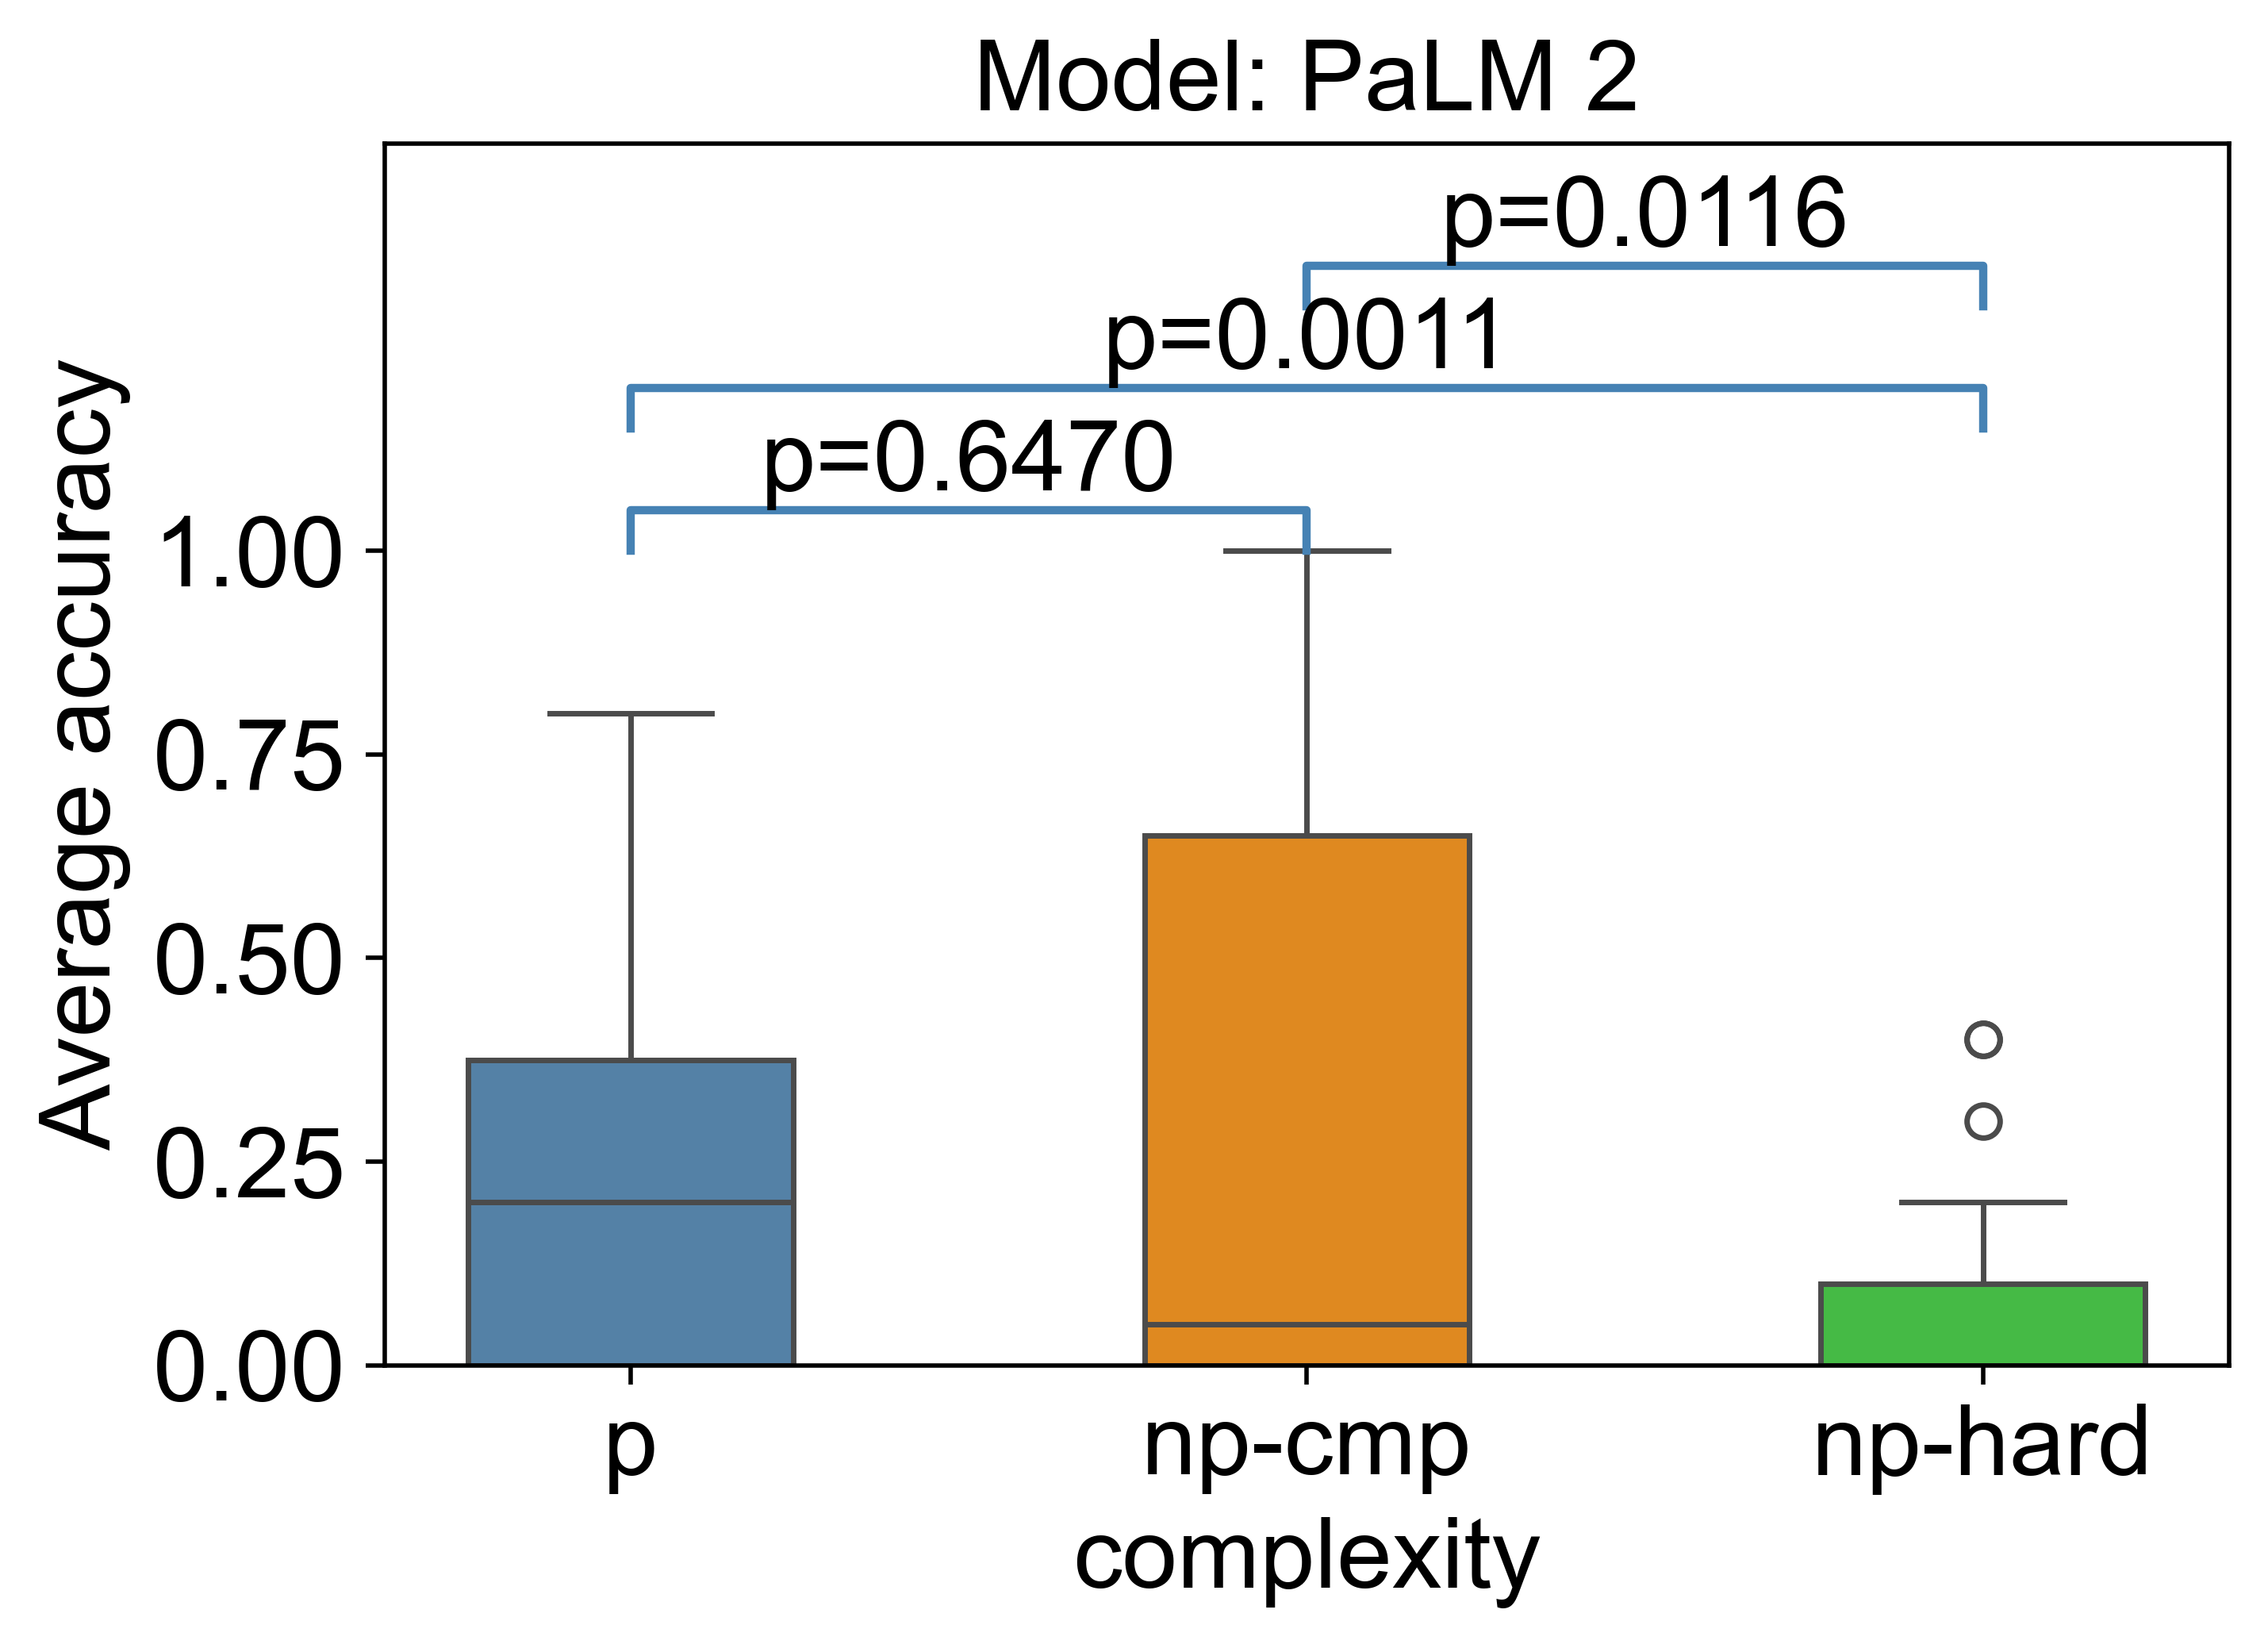

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_4994/2315669125.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.03467322229696966, 0.0004159771847177968, 0.00014883343728184787]


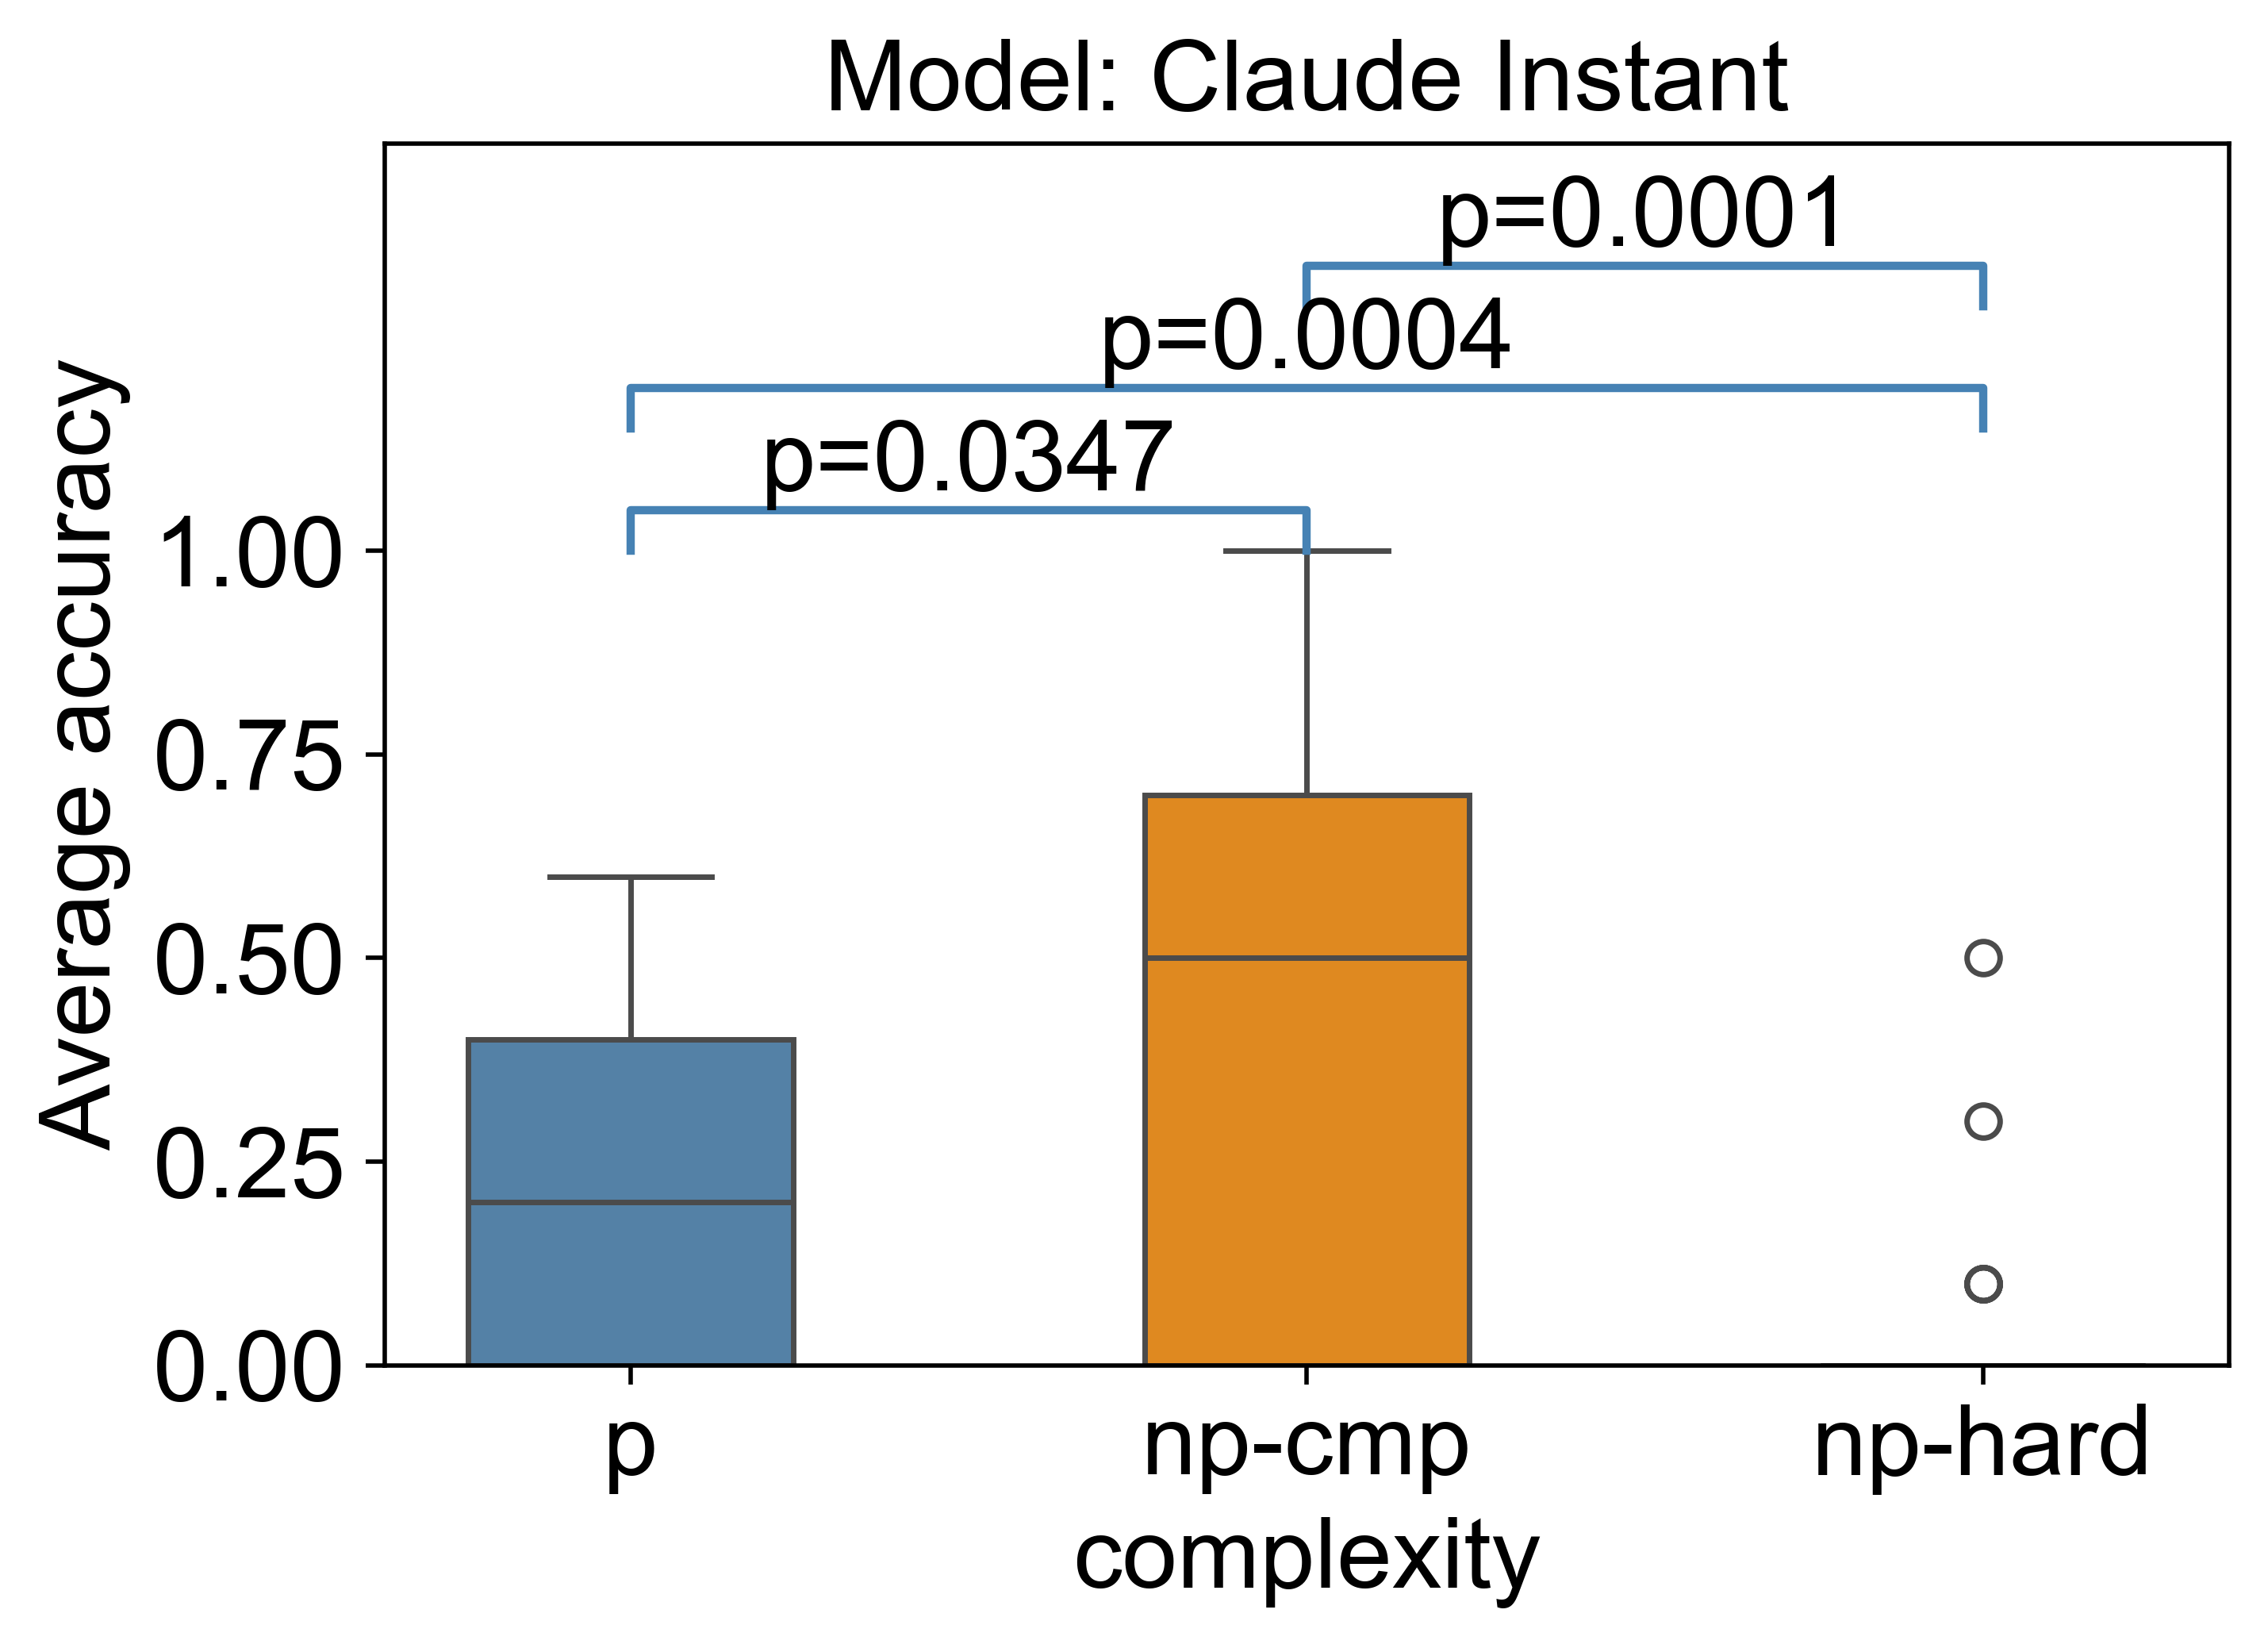

In [95]:
models = df['model'].unique()
for model in models:
    create_figure(model_df, model)